# Data Exploration
<p>
    This notebook should contain preliminary data exploration and graphing of the data set.
</p>
<p>
    Last modified 4/26/18 by Kate Baumli
</p>

In [33]:
import pandas as pd
import numpy as np
import re
import nltk
import math
import operator
import seaborn as sns
import matplotlib.pyplot as plt
import gender_guesser.detector as gender
import xgboost as xgb
from sklearn.cluster import KMeans
from collections import Counter
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import roc_auc_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn import datasets
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
nltk.download('stopwords')
import os
import random

from sklearn.feature_extraction import text
from sklearn.model_selection import cross_val_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/katebaumli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

First load up the data. Note this data was cleaned using clean.sh. We dropped NaNs, ran sentiment scores on polarity and subjectivity, removed nonwords, punctuation, and symbols from the transcripts and placed them in the column "clean_transcripts"

In [34]:
filepath = '../data/kaggle-data/'
filename = 'merged_data.csv'
data = pd.read_csv(filepath + filename)
johnsData = pd.read_csv(filepath + filename) 
# drop extra index columns
data.drop('Unnamed: 0', axis=1, inplace=True)
data.drop('Unnamed: 0.1', axis=1,inplace=True)
data.drop('Unnamed: 0.1.1', axis=1,inplace=True)
johnsData.drop('Unnamed: 0', axis=1, inplace=True)
johnsData.drop('Unnamed: 0.1', axis=1,inplace=True)
johnsData.drop('Unnamed: 0.1.1', axis=1,inplace=True)

In [35]:
# Output suppressed
#data.describe()
#data.info()
#data.head()
johnsData.head()

,transcript,url,clean_transcripts,comments,description,duration,event,film_date,languages,main_speaker,...,ratings,related_talks,speaker_occupation,tags,title,url.1,views,stripped_transcripts,polarity,subjectivity
0,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...,good morninghow are you\nlaughter\nits been gr...,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,...,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,"['good', 'morninghow', 'are', 'you', 'laughter...",0.146452,0.462051
1,"Thank you so much, Chris. And it's truly a gre...",https://www.ted.com/talks/al_gore_on_averting_...,"thank you so much, chrisand its truly a great ...",265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,...,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520,"['thank', 'you', 'so', 'much,', 'chrisand', 'i...",0.157775,0.424101
2,"(Music: ""The Sound of Silence,"" Simon & Garfun...",https://www.ted.com/talks/david_pogue_says_sim...,"music: the sound of silence, simon & garfunkel...",124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,...,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292,"['music:', 'the', 'sound', 'of', 'silence,', '...",0.136579,0.475229
3,If you're here today and I'm very happy that ...,https://www.ted.com/talks/majora_carter_s_tale...,if youre here today and im very happy that yo...,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,...,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",Activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",Greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale...,1697550,"['if', 'youre', 'here', 'today', 'and', 'im', ...",0.082928,0.439165
4,"About 10 years ago, I took on the task to teac...",https://www.ted.com/talks/hans_rosling_shows_t...,"about 10 years ago, i took on the task to teac...",593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,...,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",Global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",The best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_t...,12005869,"['about', '10', 'years', 'ago,', 'i', 'took', ...",0.096483,0.450631


In [4]:
genDetector = gender.Detector()
speaker_names = johnsData.main_speaker.tolist()

print ("Gathering gender data and adding it to data set...")

# Get gender data
first_names = []
genders = []
for name in speaker_names:
    first_last = name.split(' ')
    first = first_last[0]
    first_names.append(first)
    genders.append(genDetector.get_gender(first))

for i, gender in enumerate(genders):
    if gender == 'mostly_male':
        genders[i] = 'male'
    if gender == 'mostly_female':
        genders[i] = 'female'
    if gender == 'andy':
        genders[i] = 'unknown'

print("Current number of data points is {}".format(johnsData.shape[0]))
print("Dropping unknown genders from data set...")
johnsData['gender'] = genders
johnsData = johnsData[johnsData.gender != 'unknown']
print("After dropping, there are {} data points".format(johnsData.shape[0]))

# Convert to 0 and 1
#pd.Series(np.where(df.gender.values == 'male', 1, 0), df.index)
johnsData.replace('male', 0, inplace=True)
johnsData.replace('female', 1, inplace=True)
print("Labels converted to {}".format(type(johnsData.gender.values)))

Gathering gender data and adding it to data set...
Current number of data points is 2463
Dropping unknown genders from data set...
After dropping, there are 2152 data points
Labels converted to <class 'numpy.ndarray'>


In [5]:
# Output suppressed, this is to check data was cleaned properly
#print(data.clean_transcripts[0]) 

### Let's look at how our features are correlated:

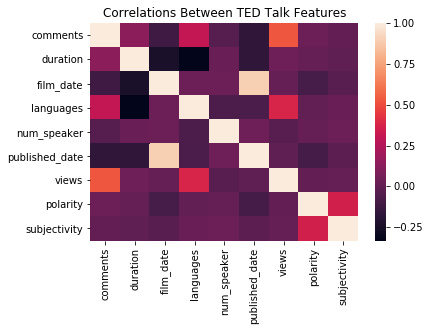

In [36]:
correlations = data.corr()
_ = sns.heatmap(correlations)
_ = plt.title('Correlations Between TED Talk Features')
plt.show()

Nothing too shocking here. We see that publish date and film date are correlated, as would be expected. We also see that views and comments are correlated, again, no shock there.

### Let's see what some of our features look like over time: 

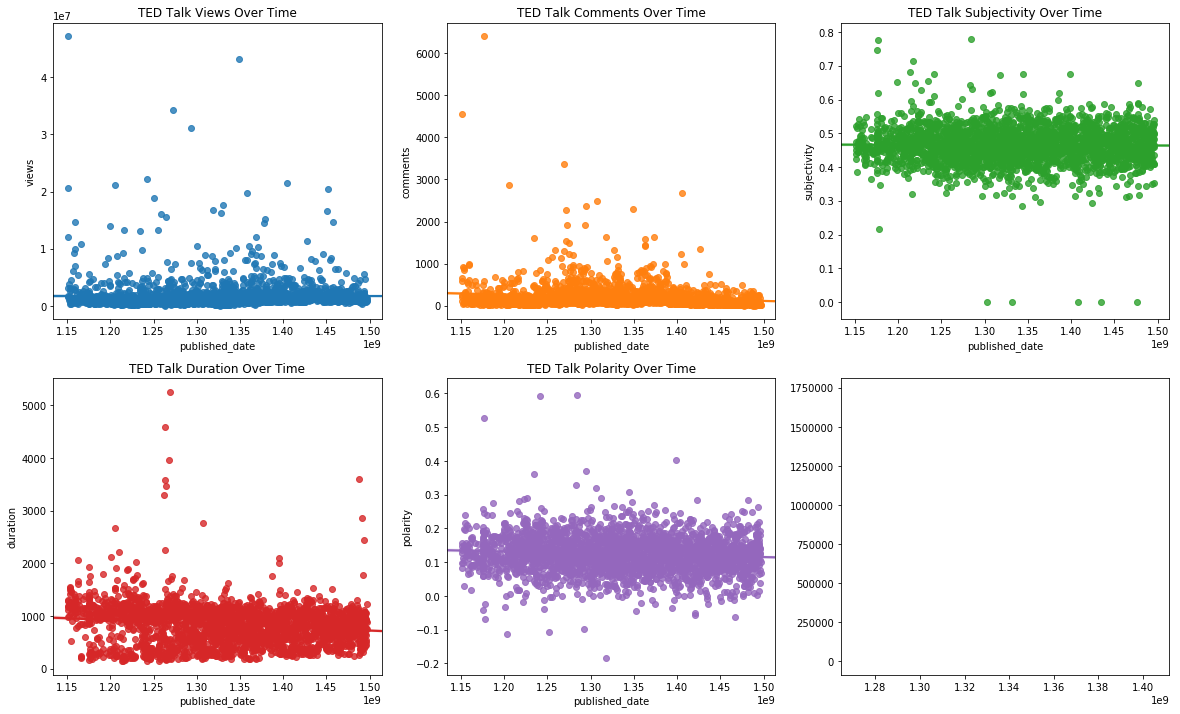

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))

# Views
_ = sns.regplot(x='published_date',y='views',data=data,ax=axes[0,0])
_ = axes[0,0].set_title('TED Talk Views Over Time')

# Comments
_ = sns.regplot(x='published_date',y='comments',data=data,ax=axes[0,1])
_ = axes[0,1].set_title('TED Talk Comments Over Time')

# Subjectivity
_ = sns.regplot(x='published_date',y='subjectivity',data=data,ax=axes[0,2])
_ = axes[0,2].set_title('TED Talk Subjectivity Over Time')

# Duration 
_ = sns.regplot(x='published_date',y='duration',data=data,ax=axes[1,0])
_ = axes[1,0].set_title('TED Talk Duration Over Time')

# Polarity
_ = sns.regplot(x='published_date',y='polarity',data=data,ax=axes[1,1])
_ = axes[1,1].set_title('TED Talk Polarity Over Time')


plt.show()

In [8]:
## Let's parse through some of the non-numeric data and make it numeric!

In [84]:
rating_counts = {'Longwinded':[],'Courageous':[],'Obnoxious':[],'Fascinating':[],'OK':[],'Inspiring':[],'Beautiful':[],
                'Confusing':[],'Funny':[],'Persuasive':[],'Informative':[],'Ingenious':[],'Unconvincing':[],'Jaw-dropping':[]}

for row in data.itertuples():
    ratings = eval(row.ratings)
    done_ratings = set()
    
    for rating in ratings: 
        name = rating['name']
        done_ratings.add(name) # Add to the set of ratings we've seen this talk tagged as
        count = rating['count']
        rating_counts[name].append(count)
        
    for key in rating_counts.keys():
        if key not in done_ratings:
            rating_counts[key].append(0)  # The tag wasn't used for the talk by anyone, 0 is the count
    done_ratings.clear() 

# Add rating counts to dictionary and remove the old ratings category 
for key,value in rating_counts.items():
    data[key] = value
_ = data.drop(labels = ['ratings'],axis=1)
#data.head()

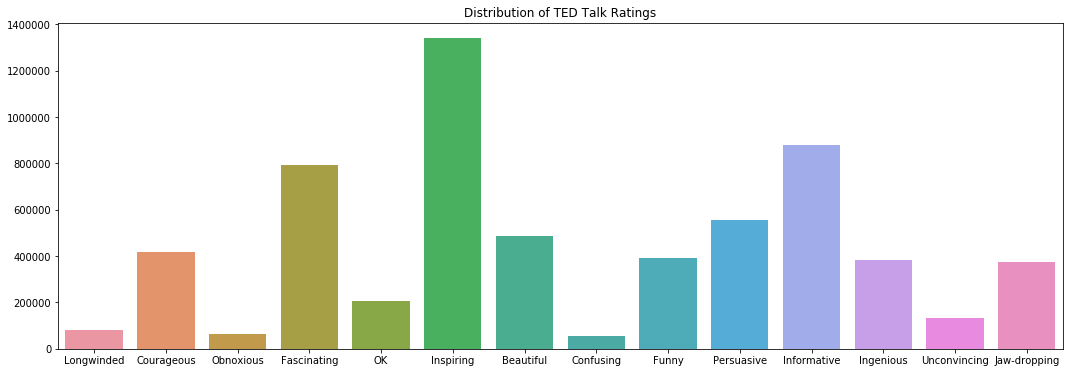

In [85]:
# Let's see what the most commonly used tags are
total_counts = []
for k,v in rating_counts.items():
    total_counts.append(np.sum(v))
    
_ = fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
_ = sns.barplot(x = list(rating_counts.keys()),y=total_counts,ax = axes)
_ = plt.title('Distribution of TED Talk Ratings')
plt.show()

Inspiring is by far the most used rating, and all of the negative ratings occur far less frequently than the positive ratings do.

In [8]:
# Find transcript with the most words
maxLen = 0
for row in data.itertuples():
    if len(row.clean_transcripts.split()) >= maxLen:
        maxLen = len(row.clean_transcripts.split()) 
        longestTalk = row.name
print(maxLen)
print(longestTalk)

8760
Zeynep Tufekci: Machine intelligence makes human morals more important


In [38]:
def getWords(df,removeStopWords):
    words = []
    for row in df.itertuples():
        words.extend(row.clean_transcripts.split())
    
    # Removing Stopwords ('the', 'it', 'is', 'and', etc)
    if removeStopWords:
        stopWords = set(stopwords.words('english'))
        print("Removing the stop words... ")
        
        filteredWords =[]
        for word in words: 
            if word not in stopWords:
                filteredWords.append(word)
                
        return filteredWords
    
    return words

In [39]:
def mostFrequentWords(df, numWordsDesired, descriptor='', removeStopWords=True, normalize=False):
    # This loops over all rows in the clean transcripts column and 
    # puts every word in every transcript into a list called words
    words = getWords(df,removeStopWords)
    
    descriptor2=''
    if removeStopWords:
        descriptor2 = '(excluding stop words like \'the\')'
    
    # Get counts for each word
    wordCounts = Counter(words)
    print(descriptor,'Number of unique words:',descriptor2,len(wordCounts))

    # Grab the most common words
    mostCommon = dict()
    for word, wordCount in wordCounts.most_common(numWordsDesired):
        if normalize:
            # Divide by total # of words to get percentage of words said
            mostCommon[word] = wordCount/float(len(words)) 
        else:
            mostCommon[word] = wordCount
    # Plot a histogram
    _ = plt.figure(figsize=(20,10))
    _ = sns.barplot(list(mostCommon.keys()), list(mostCommon.values()))
    title = ('The '+str(numWordsDesired)+' Most Common Words ' + descriptor2 +
             ' In All ' + descriptor +' TED Talk Transcripts')
    _ = plt.title(title)
    _ = plt.xticks(rotation=300)
    plt.show()
    
    # Return list of most common words
    return mostCommon

Removing the stop words... 
 Number of unique words: (excluding stop words like 'the') 234988


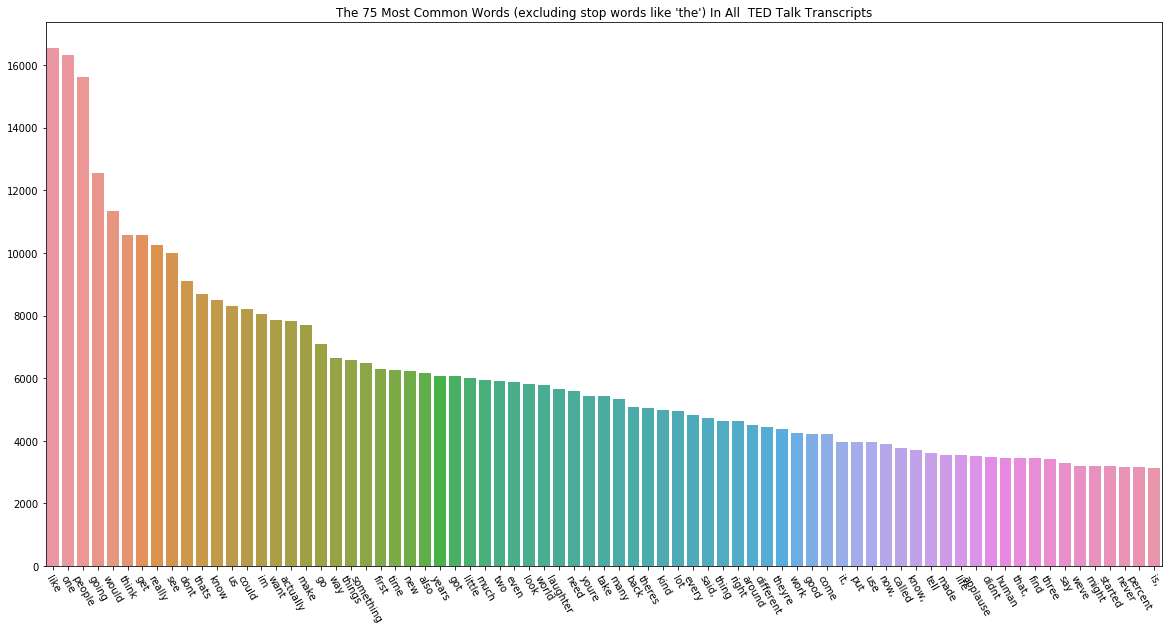

In [40]:
_ = mostFrequentWords(data,75)

### Let's break the data set into two segments based on (guessed) speaker gender.

In [41]:
genDetector = gender.Detector()
speakerNames = data.main_speaker.tolist()

speakerFirstNames = []
genders = []
for name in speakerNames:
    firstLastName = name.split(' ')
    firstName = firstLastName[0]
    speakerFirstNames.append(firstName)
    genders.append(genDetector.get_gender(firstName))
data['gender'] = genders

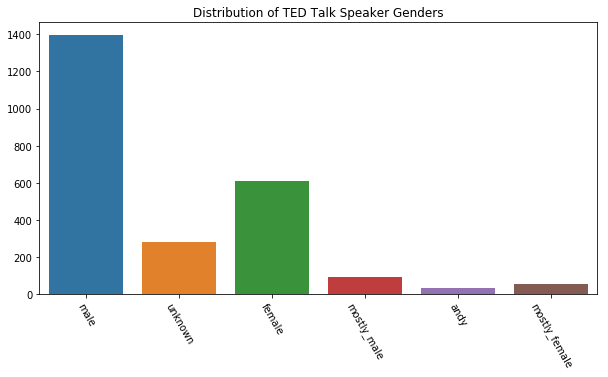

In [42]:
# Plot a histogram of genders
genderCounts = Counter(genders)
_ = plt.figure(figsize=(10,5))
_ = sns.barplot(list(genderCounts.keys()), list(genderCounts.values()))
title = 'Distribution of TED Talk Speaker Genders'
_ = plt.title(title)
_ = plt.xticks(rotation=300)
plt.show()

Let's go ahead and add the "mostly_female" names to female category and "mostly_male" names to male category.

In [43]:
for i,gender in enumerate(genders):
    if gender == 'mostly_male':
        genders[i] = 'male'
    if gender == 'mostly_female':
        genders[i] = 'female'
    if gender == 'andy':
        genders[i] = 'unknown' # No need to have 2 unknown categories if we're going to have to manually label anyways

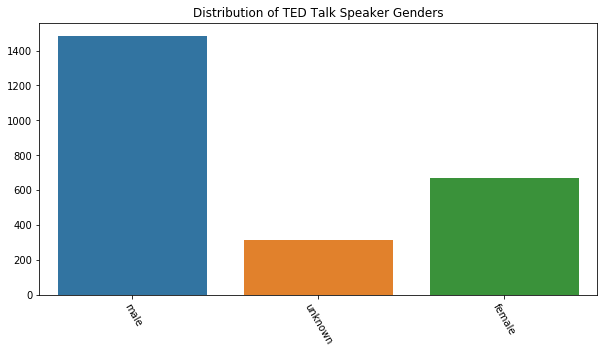

In [44]:
data['gender'] = genders
# Replot a histogram of genders
genderCounts = Counter(genders)
_ = plt.figure(figsize=(10,5))
_ = sns.barplot(list(genderCounts.keys()), list(genderCounts.values()))
title = 'Distribution of TED Talk Speaker Genders'
_ = plt.title(title)
_ = plt.xticks(rotation=300)
plt.show()

Aman went through and manualy labeled the 311 unknown gender speakers and came up with gender labels for each "unknown" labeled index:

In [45]:
maleIndexes = {21,32,35,48,58,64,78,92,102,124,130,134,135,144,154,171,175,194,222,233,249,261,270,289,317,320,324,360,371,393,415,419,449,480,482,484,485,487,512,523,553,556,570,577,583,587,591,593,594,597,599,608,624,627,632,723,732,747,761,780,781,790,797,810,837,879,880,896,897,900,905,919,957,959,962,966,979,1005,1010,1011,1018,1024,1038,1040,1081,1085,1090,1091,1100,1110,1113,1133,1137,1168,1180,1184,1198,1203,1225,1232,1235,1261,1270,1271,1272,1278,1363,1377,1383,1392,1395, 1397, 1398, 1407, 1423,1425, 1427,1437,1471,1474,1482,1505,1540,1548,1560,1583,1598,1605,1615,1640,1666,1684,1685,1706,1707,1746,1756,1766,1767,1772,1775,1782,1789,1791,1806,1814,1820,1825,1859,1872,1877,1887,1895,1927,1931,1944,1955,1972,2005,2012,2021,2042,2059,2081,2124,2159,2164,2176,2206,2223,2231,2238,2242,2247,2250,2288,2297,2300,2307,2309,2312,2338,2340,2394,2414,2418,2431,2437,2444,2450,2460}
femaleIndexes = {3,11,15,110,128,190,209,237,281,282,323,393,459,474,530,555,607,622,651,654,673,694,767,836,840,863,878,941,983,1000,1021,1027,1037,1089,1110,1149,1152,1177,1188,1189,1222,1248,1259,1275,1278,1305,1316,1332,1339,1412,1428,1451,1460,1505,1489,1495, 1512,1532,1539,1541,1562,1573,1587,1621,1626,1679,1703,1712,1721,1737,1748,1754,1761,1797,1819,1844,1856,1857,1883,1941,1945,1961,1975,1984,1992,2003,2010,2013,2049,2054,2067,2087,2088,2098,2099,2103,2112,2122,2128,2134,2157,2158,2168,2178,2193,2194,2222,2224,2257,2271,2294,2313,2325,2349,2361,2369,2375,2380,2382,2407,2419,2420,2429,2430,2455,2457}

In [46]:
for row in data.itertuples():
    # All this 'oldIndex' junk is to adjust for the 4 rows
    # we dropped after Aman labeled all of these indexes as male
    # or female. After we pass the index of each entry we dropped,
    # the index is actaully 1 less than the index aman wrote down,
    # so we add 1 to compensate.
    oldIndex = row[0]
    if row[0] > 152: 
        oldIndex += 1
    if row[0] > 574:
        oldIndex += 1
    if row[0] > 1373:
        oldIndex += 1
    if row[0] > 1922:
        oldIndex += 1
    if row.gender == 'unknown':
        if oldIndex in maleIndexes:
            data.loc[row[0],'gender'] = 'male'
        elif oldIndex in femaleIndexes:
            data.loc[row[0],'gender'] = 'female'
        else:
            print(row[0])

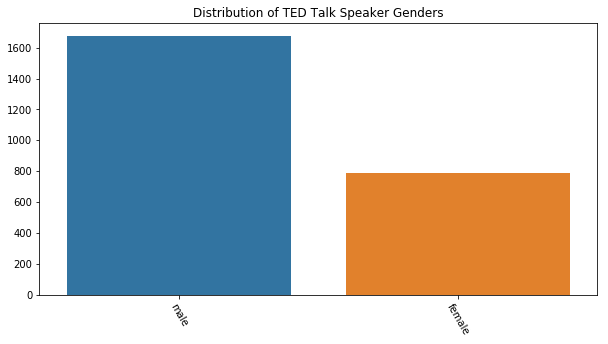

In [47]:
# Replot a histogram of genders
genderCounts = Counter(data['gender'])
_ = plt.figure(figsize=(10,5))
_ = sns.barplot(list(genderCounts.keys()), list(genderCounts.values()))
title = 'Distribution of TED Talk Speaker Genders'
_ = plt.title(title)
_ = plt.xticks(rotation=300)
plt.show()

Right off the bat we can see that about twice as many speakers are men than women(disregarding the unknown). Let's compare the average # of views of men vs women.<br>
Let's go ahead and assign numbers to these labels (0 to female 1 to male) to make predictions and analysis easier. 

In [24]:
#genderBinary = label_binarize(data.gender.values,classes=['female','male'])
#data['gender'] = genderBinary

### Let's build a simple gender classifier on the original data with no new features.

In [25]:
def getTFIDFvectors(dataframe):
    scripts = dataframe['transcript'].tolist()
    tfidfGenerator = text.TfidfVectorizer(input= scripts, stop_words= "english")
    matrix = tfidfGenerator.fit_transform(scripts)
    return matrix

In [26]:
def simpleGenderClf(dataframe,numFolds = 5):
    y = dataframe['gender'].values # What we're trying to predict
    X = dataframe.drop(labels=['gender'],axis=1).select_dtypes(include=[np.number]).values # Features we are using
        
    #Let's do k fold cross validation to see how well this baseline model performs
    skf = StratifiedKFold(n_splits=numFolds)
    _ = skf.get_n_splits(X, y)
    
    # These are the metrics we want to record
    AUCs = []
    FPRs = []
    TPRs = []
    accuracies = []

    for train_index, test_index in skf.split(X, y):
        rand = np.random.randint(1, 100) # Why here?
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = LogisticRegression(penalty='l2', max_iter=1000, random_state=rand)
        _ = clf.fit(X_train, y_train)
        accuracies.append(clf.score(X_test, y_test))
        y_pred = clf.predict(X_test)
        y_pred_prob = clf.predict_proba(X_test)
        AUC = metrics.roc_auc_score(y_test,y_pred_prob[:,0])
        confusion = confusion_matrix(y_test,y_pred)
        _ = sns.heatmap(confusion)
        #plt.show()
        AUCs.append(AUC)
        
    print('AUC:',np.mean(AUCs))

Original Data Scores:
|---------------------|
|true neg  | false pos|
|----------| ---------|
|false neg | true pos |
|---------------------|
AUC: 0.574979837569


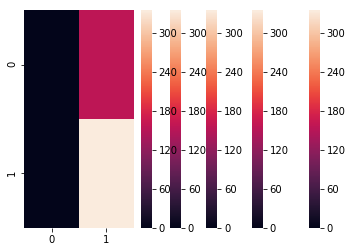

In [27]:
originalData = data.drop(labels=['polarity','subjectivity'], axis=1)
print('Original Data Scores:')
print('|---------------------|\n|true neg  | false pos|\n|----------| ---------|\n|false neg | true pos |\n|---------------------|')
simpleGenderClf(originalData)

As a baseline, our naive logistic regression predictor scores ~0.57 mean AUC across 5 validation folds. BUT IT IS PREDICTING ALL MALE AND NO FEMALE BECAUSE THE CLASSES ARE SO SKEWED.

Adding in polarity and subjectivity scores:
AUC: 0.574979837569


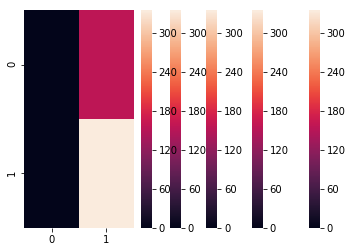

In [28]:
print('Adding in polarity and subjectivity scores:')
simpleGenderClf(data)

In [29]:
def xgbFit(mod,data,predictors,doEstimatorCV=True, numFolds=5, earlyStoppingRounds=50):
    trainData, validData = train_test_split(data, test_size=0.3, random_state=42)
    
    if doEstimatorCV:
        param = mod.get_xgb_params()
        dtrain = xgb.DMatrix(trainData[predictors].values, label=trainData['gender'].values)
        cvresult = xgb.cv(param, dtrain, num_boost_round=mod.get_params()['n_estimators'], nfold=numFolds,
            metrics='auc', early_stopping_rounds=earlyStoppingRounds,stratified=True)
        print('CV for number of estimators: ',cvresult.shape[0])
        mod.set_params(n_estimators=cvresult.shape[0])
    
    # Fit the algorithm on the training data
    mod.fit(trainData[predictors], trainData['gender'],eval_metric='auc')
        
    # Predict training set:
    dtrain_predictions = mod.predict(trainData[predictors])
    dtrain_predprob = mod.predict_proba(trainData[predictors])[:,1]
    
    # Predict on validation set
    dvalid_predictions = mod.predict(validData[predictors])
    dvalid_predprob = mod.predict_proba(validData[predictors])[:,1]
    
    # Print report for the model:
    print("Model Report:")
    print("Accuracy (Train) : %.4g" % metrics.accuracy_score(trainData['gender'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(trainData['gender'], dtrain_predprob))
    print("Accuracy (Test) : %.4g" % metrics.accuracy_score(validData['gender'].values, dvalid_predictions))
    print("AUC Score (Test): %f" % metrics.roc_auc_score(validData['gender'].values, dvalid_predprob))   
    
    # Get feature importances 
    xgb.plot_importance(mod)
    #featureImportance = pd.Series(xgb.booster().get_fscore()).sort_values(ascending=False)
    #featureImportance.plot(kind='bar', title='Feature Importances')
    #plt.ylabel('Feature Importance Score')
    

['comments', 'duration', 'film_date', 'languages', 'num_speaker', 'published_date', 'views', 'Longwinded', 'Courageous', 'Obnoxious', 'Fascinating', 'OK', 'Inspiring', 'Beautiful', 'Confusing', 'Funny', 'Persuasive', 'Informative', 'Ingenious', 'Unconvincing', 'Jaw-dropping']
CV for number of estimators:  45
Model Report:
Accuracy (Train) : 0.8881
AUC Score (Train): 0.961214
Accuracy (Test) : 0.6536
AUC Score (Test): 0.676297


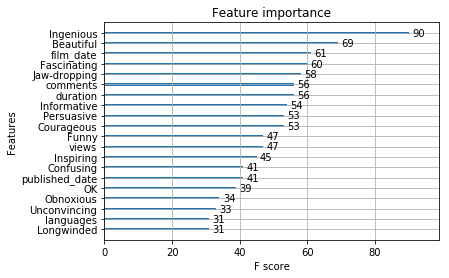

In [30]:
#Choose all predictors except target
orig_predictors = [feature for feature in data.select_dtypes(include=[np.number]).columns if feature not in ['gender','polarity','subjectivity']]
print(orig_predictors)
# Let's start somewhere, fix some parameters at standard values and go from there
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0.2,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=0.47, # Ratio of neg to pos classes
 seed=27)

xgbFit(xgb1, data, orig_predictors)

['comments', 'duration', 'film_date', 'languages', 'num_speaker', 'published_date', 'views', 'polarity', 'subjectivity', 'Courageous', 'OK', 'Informative', 'Confusing', 'Jaw-dropping', 'Longwinded', 'Ingenious', 'Funny', 'Obnoxious', 'Unconvincing', 'Persuasive', 'Inspiring', 'Beautiful', 'Fascinating']
CV for number of estimators:  59
Model Report:
Accuracy (Train) : 0.92
AUC Score (Train): 0.981834
Accuracy (Test) : 0.6401
AUC Score (Test): 0.660379


/home/humble-fool/school_work/Spring_18/Data-Science-Lab-Final-Project/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/humble-fool/school_work/Spring_18/Data-Science-Lab-Final-Project/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


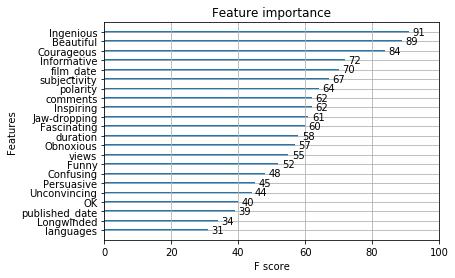

In [32]:
predictors_with_sentiments = [feature for feature in data.select_dtypes(include=[np.number]).columns if feature not in ['gender']]
print(predictors_with_sentiments)

xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0.2,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=0.47, # Ratio of neg to pos classes
 seed=27)

xgbFit(xgb1, data, predictors_with_sentiments)

All of our scores seemed to improve when we added in our sentiment scores (for polarity and subjectivity). That's awesome.

In [48]:
menTED = data[data['gender'] == 'male']
womenTED = data[data['gender'] == 'female']
#print('Description of male speaker TED data:')
#menTED.describe()
#print('Description of female speaker TED data:')
#womenTED.describe()

Let's compare the frequency of words:

Removing the stop words... 
Male Speaker Number of unique words: (excluding stop words like 'the') 183977


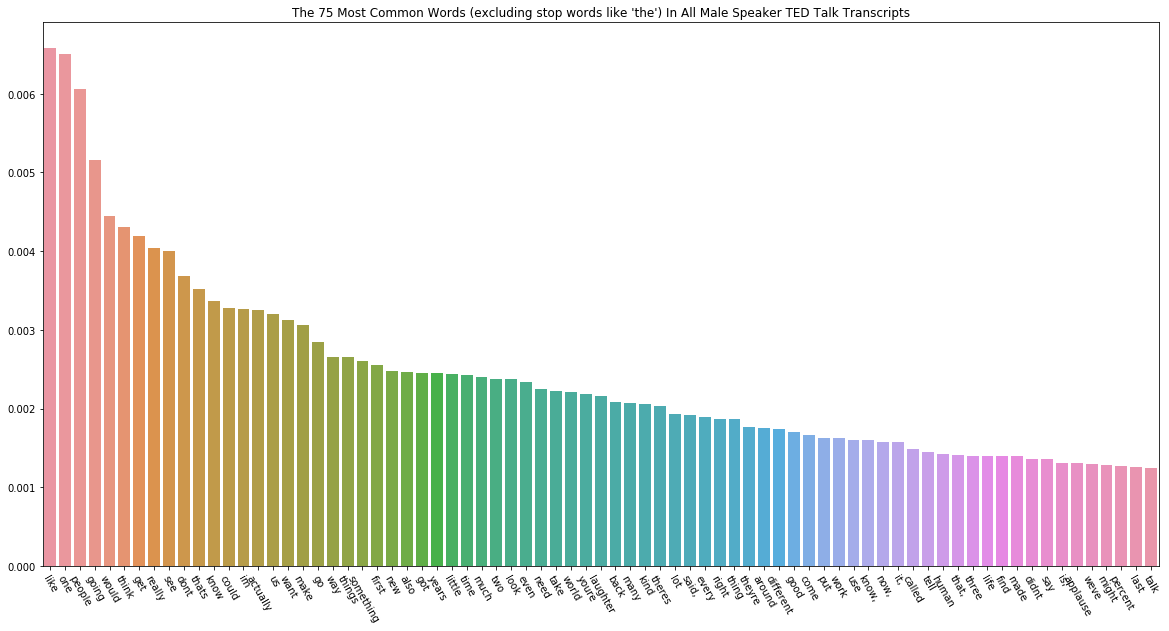

Removing the stop words... 
Female Speaker Number of unique words: (excluding stop words like 'the') 104353


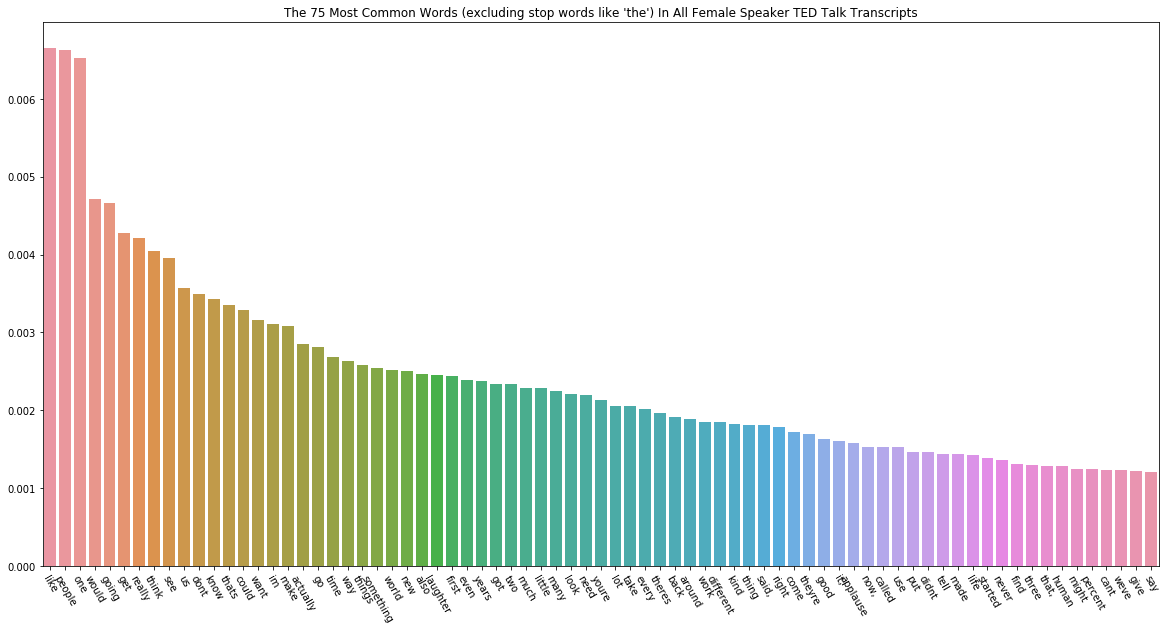

In [49]:
maleCommonWords = mostFrequentWords(menTED,75,'Male Speaker',normalize=True)
femaleCommonWords = mostFrequentWords(womenTED,75,'Female Speaker',normalize=True)

It's also interesting that men seem to pause more frequently than do women.

### Previous research on the differences of speech patterns between men and women, we have found that women are more likely to use speech qualifiers/intensifiers such as 'very','so','such','extremely','really','totally','absolutely', or 'too'. Let's look into that a little more here and compare our talks:

In [50]:
def getNormalizedGenderWordCounts():
    maleWords = getWords(menTED,removeStopWords=True)
    femaleWords = getWords(womenTED,removeStopWords=True)

    # Get counts for each word
    maleWordCounts = Counter(maleWords)
    femaleWordCounts = Counter(femaleWords)

    # Normalize counts by number of total words spoken by men 
    normalizedMaleWordCounts = {}
    for word,count in dict(maleWordCounts).items():
        normalizedMaleWordCounts[word] = count/float(len(maleWords))

    # Normalize counts by number of total words spoken by women 
    normalizedFemaleWordCounts = {}
    for word,count in dict(femaleWordCounts).items():
        normalizedFemaleWordCounts[word] = count/float(len(femaleWords))
        
    return normalizedMaleWordCounts, normalizedFemaleWordCounts

In [51]:
def menVsWomenWordCounts(wordsToCount):    
    normalizedMaleWordCounts, normalizedFemaleWordCounts = getNormalizedGenderWordCounts()
    maleCount = 0
    for word,count in normalizedMaleWordCounts.items():
        if word in wordsToCount:
            maleCount += count
        
    femaleCount = 0
    for word,count in normalizedFemaleWordCounts.items():
        if word in wordsToCount:
            femaleCount += count
            
    return maleCount, femaleCount

In [52]:
intensifiers = ['very','so','such','really','totally','too']
maleIntensifierCount, femaleIntensifierCount = menVsWomenWordCounts(intensifiers)

print('Percentage of intensifier words for men:  ',maleIntensifierCount)
print('Percentage of intensifier words for women:',femaleIntensifierCount)

Removing the stop words... 
Removing the stop words... 
Percentage of intensifier words for men:   0.0042368323967622665
Percentage of intensifier words for women: 0.004415542917221777


Some other studies https://www.washingtonpost.com/news/the-intersect/wp/2016/05/28/these-are-the-words-most-associated-with-men-and-women-according-to-facebook-status-updates/?noredirect=on&utm_term=.54981ab1318a have shown that women tend to use words that are more "warm and agreeable"

In [38]:
uncertainty = ['um','uh','-']
maleUncertaintyCount, femaleUncertaintyCount = menVsWomenWordCounts(uncertainty)
print('Percentage of uncertainty words for men:  ',maleUncertaintyCount)
print('Percentage of uncertainty words for women:',femaleUncertaintyCount)

Removing the stop words... 
Removing the stop words... 
Percentage of uncertainty words for men:   1.4456231734551204e-05
Percentage of uncertainty words for women: 7.730743362512595e-06


Flagging um and uh might prove useful in differentiating between genders

In [39]:
warmAndAgreeable = ['family','friends','wonderful','blessed','amazing','loving','husband','thankful']
maleWarmAgreeableCount, femaleWarmAgreeableCount = menVsWomenWordCounts(warmAndAgreeable)

print('Percentage of warm and agreeable words for men:  ',maleWarmAgreeableCount)
print('Percentage of warm and agreeable words for women:',femaleWarmAgreeableCount)

Removing the stop words... 
Removing the stop words... 
Percentage of warm and agreeable words for men:   0.0015046045989320891
Percentage of warm and agreeable words for women: 0.0018012632034654344


'Warm and agreeable' words could be useful to flag!

In [40]:
coldHearted = ['kill','kills','dead','killing','die','swear','dead','murder']
maleColdHeartedCount, femaleColdHeartedCount = menVsWomenWordCounts(coldHearted)

print('Percentage of cold hearted words for men:  ',maleColdHeartedCount)
print('Percentage of cold hearted words for women:',femaleColdHeartedCount)

Removing the stop words... 
Removing the stop words... 
Percentage of cold hearted words for men:   0.0005597452927618227
Percentage of cold hearted words for women: 0.0007009207315344753


'Cold hearted' words seem to be slightly more frequent for women than men. 

In [41]:
rational = ['opinion','opinions','logic','logical','based','political','fact','moral','beliefs']
maleRationalCount, femaleRationalCount = menVsWomenWordCounts(rational)
print('Percentage of rational words for men:  ',maleRationalCount)
print('Percentage of rational words for women:',femaleRationalCount)

Removing the stop words... 
Removing the stop words... 
Percentage of rational words for men:   0.0014618141529978176
Percentage of rational words for women: 0.0015190910707337248


Let's compare speed of speech of men and women. 

In [53]:
WPM = []
for row in data.itertuples():
    minutes = row.duration/float(60) # Duration is in seconds
    numWords = len(row.clean_transcripts.split(' '))
    WPM.append(numWords/float(minutes))
data['WPM'] = WPM

WPM = []
for row in johnsData.itertuples():
    minutes = row.duration/float(60) # Duration is in seconds
    numWords = len(row.clean_transcripts.split(' '))
    WPM.append(numWords/float(minutes))
johnsData['WPM'] = WPM

In [63]:
def compareGenders(feature):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
    # violin plots in seaborn require 2 catagorical variables ('x' and 'hue'). We use 'gender' for hue.
    placeholder = np.zeros(len(data[feature].values))
    _ = sns.violinplot(x=placeholder, y=data[feature], hue=data.gender,split=True,ax=axes[0], palette='bright')
    _ = axes[0].set_title('Comparing Distribution of '+feature+ ' by Gender')
    _ = sns.boxplot(x=placeholder,y=data[feature],hue=data.gender, ax = axes[1])
    _ = axes[1].set_title('Comparing Distribution of '+feature+ ' by Gender')
    plt.show()

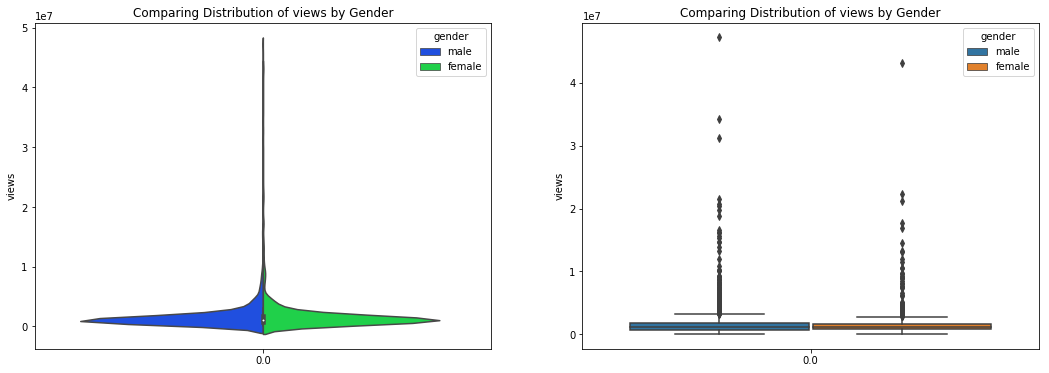

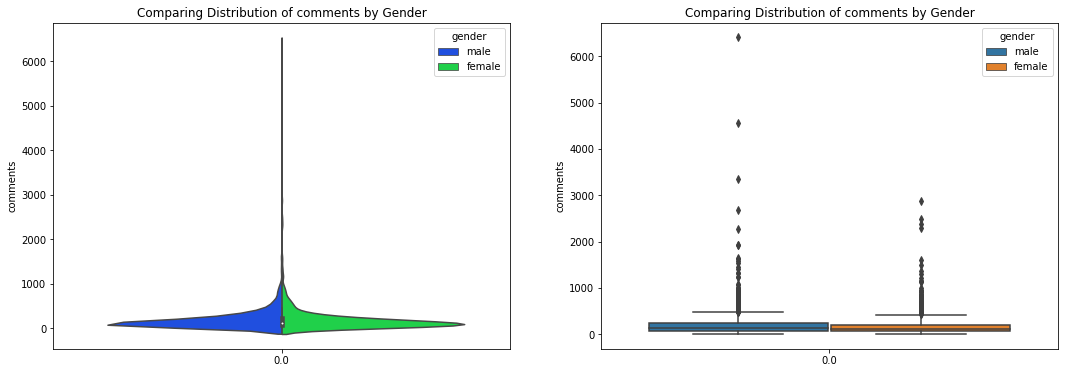

In [68]:
compareGenders('views')
compareGenders('comments')

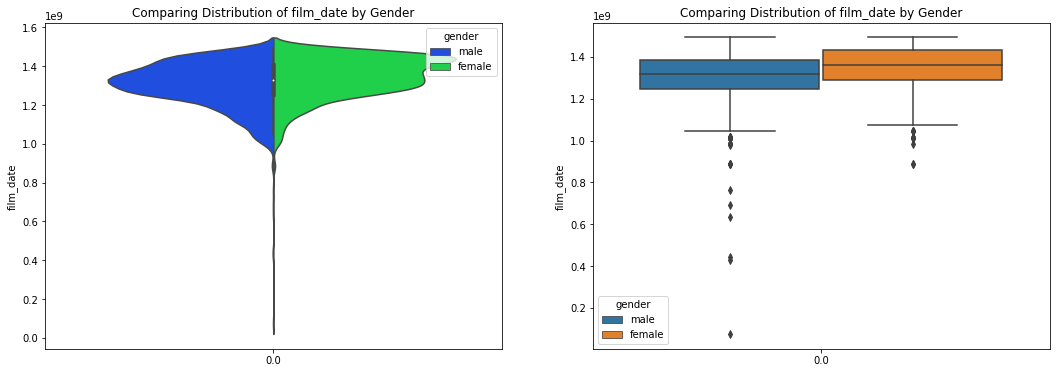

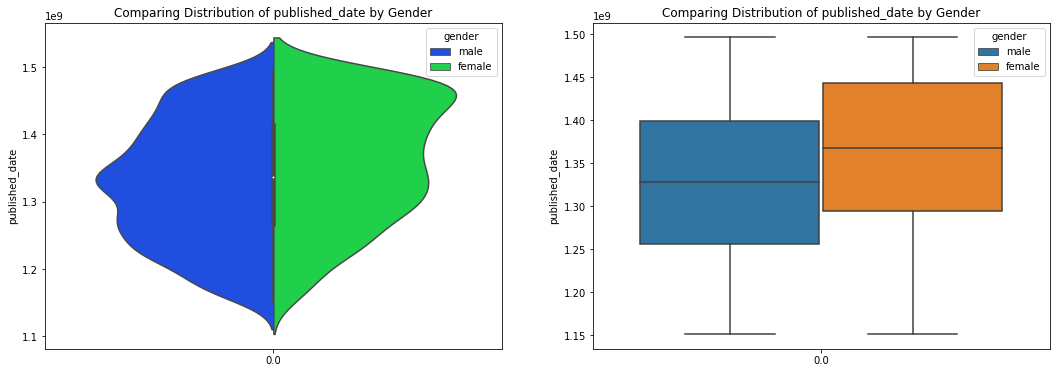

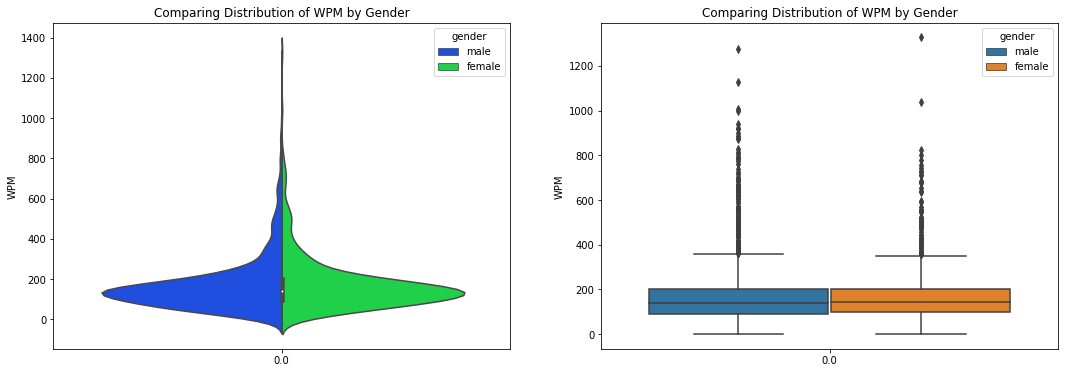

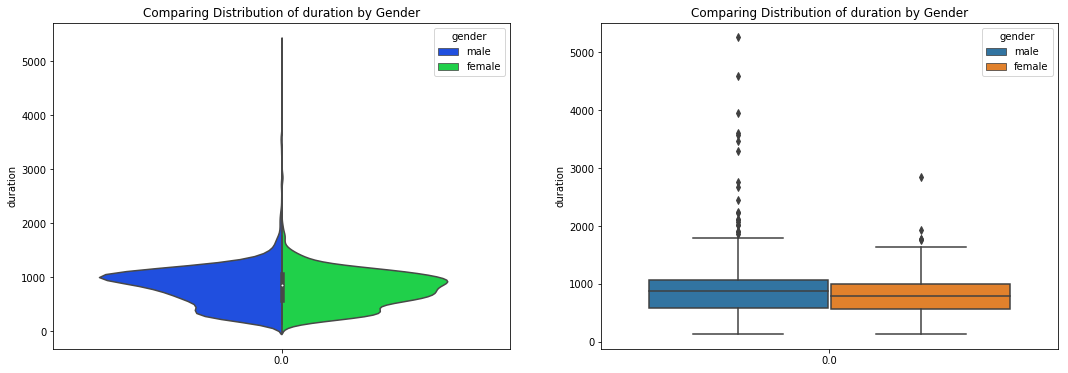

In [69]:
compareGenders('film_date')
compareGenders('published_date')
compareGenders('WPM')
compareGenders('duration')

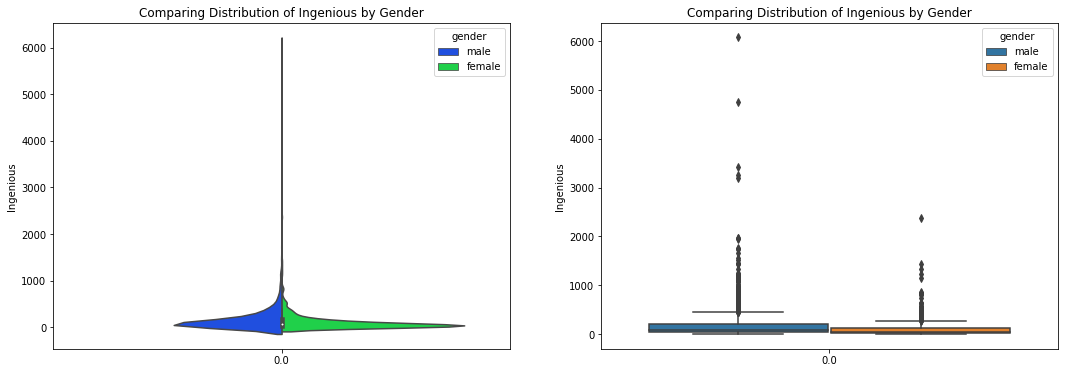

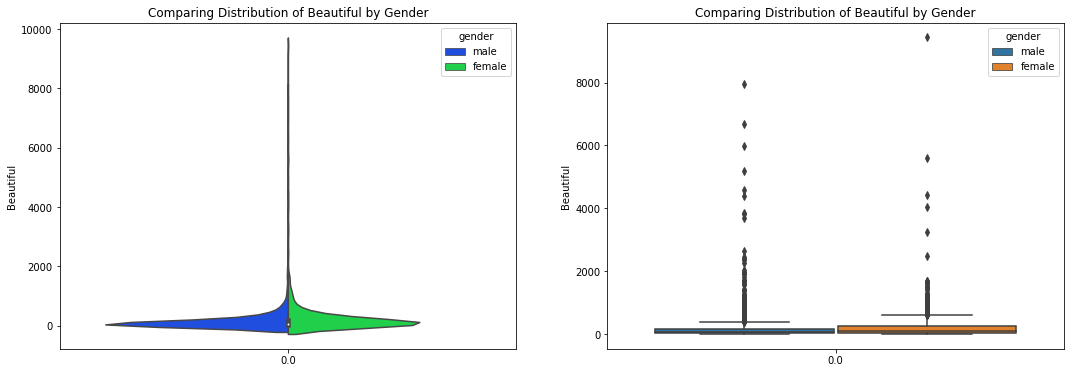

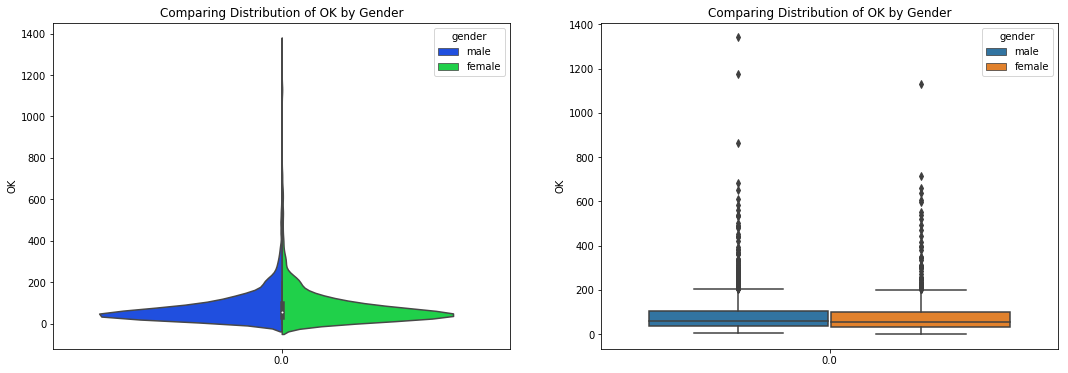

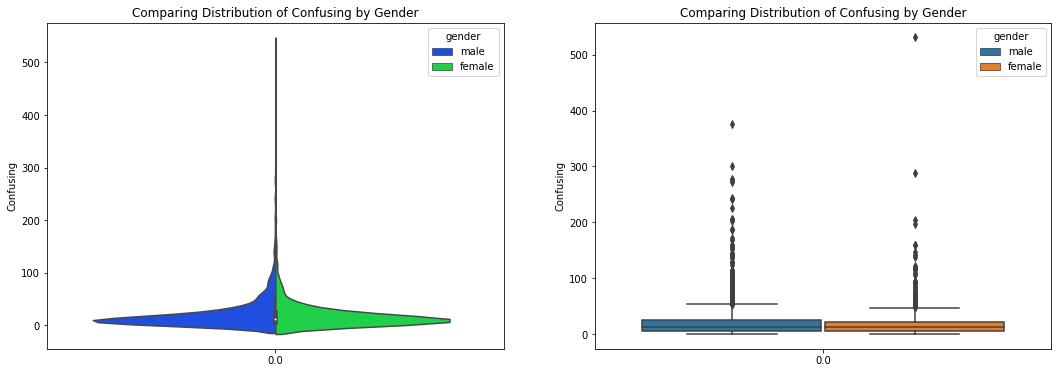

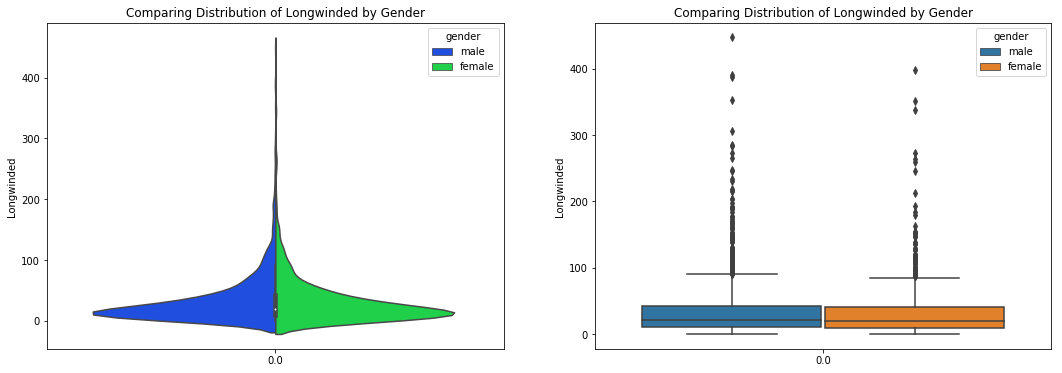

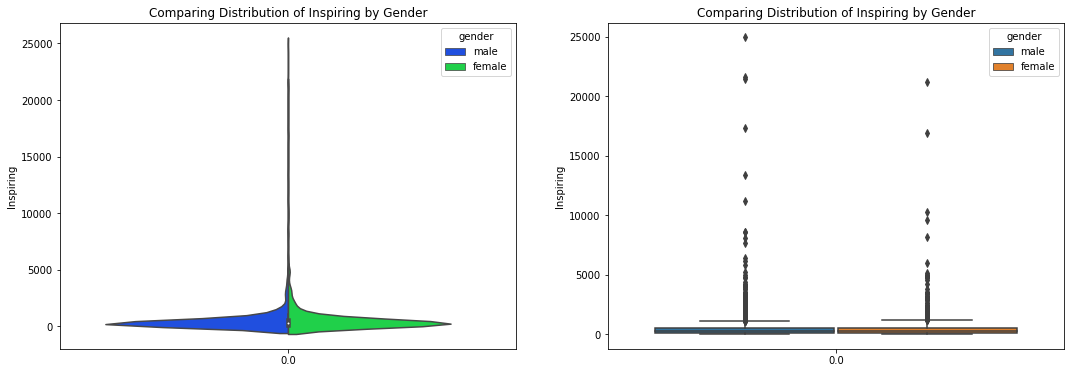

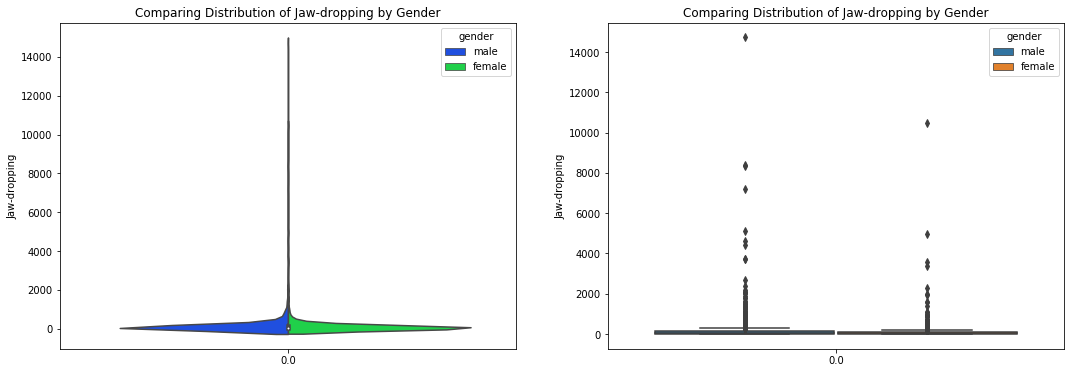

In [86]:
compareGenders('Ingenious')
compareGenders('Beautiful')
compareGenders('OK')
compareGenders('Confusing')
compareGenders('Longwinded')
compareGenders('Inspiring')
compareGenders('Jaw-dropping')

Duration and published date seem to correlate with gender based on the plots above. These features could be useful to highlight when building a gender classifier. 

['comments', 'duration', 'film_date', 'languages', 'num_speaker', 'published_date', 'views', 'polarity', 'subjectivity', 'Courageous', 'OK', 'Informative', 'Confusing', 'Jaw-dropping', 'Longwinded', 'Ingenious', 'Funny', 'Obnoxious', 'Unconvincing', 'Persuasive', 'Inspiring', 'Beautiful', 'Fascinating', 'WPM']
CV for number of estimators:  59
Model Report:
Accuracy (Train) : 0.9182
AUC Score (Train): 0.981318
Accuracy (Test) : 0.6455
AUC Score (Test): 0.664754


/home/humble-fool/school_work/Spring_18/Data-Science-Lab-Final-Project/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/humble-fool/school_work/Spring_18/Data-Science-Lab-Final-Project/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


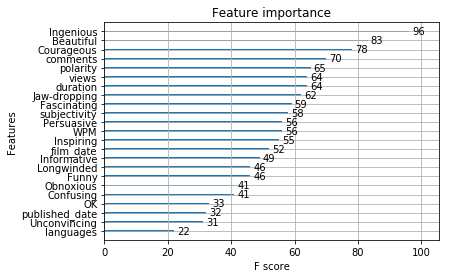

In [46]:
new_predictors = [feature for feature in data.select_dtypes(include=[np.number]).columns if feature not in ['gender']]
print(new_predictors)
xgbFit(xgb1, data, new_predictors)

All of our scores improved again when adding in WPM as a feature!

Now let's compare the amount of (laughter) and (applause) recieved by men and women normalized by the length of the talk.

In [73]:
laughter = []
applause = []
for row in data.itertuples():
    words = row.clean_transcripts.split() # Not the cleaned transcripts because those take out the () around laughter and applause
    laughCount = 0
    applauseCount = 0
    for word in words:
        if word == 'laughter':
            laughCount += 1
        if word == 'applause':
            applauseCount += 1
    laughter.append(laughCount/float(len(words))) # laugh to words ratio
    applause.append(applauseCount/float(len(words))) # applause to words ratio

data['laughter_ratio'] = laughter
data['applause_ratio'] = applause


applause = []
for row in johnsData.itertuples():
    words = row.clean_transcripts.split() # Not the cleaned transcripts because those take out the () around laughter and applause
    applauseCount = 0
    for word in words:
        if word == 'applause':
            applauseCount += 1
    applause.append(applauseCount/float(len(words))) # applause to words ratio

In [97]:
male_rating_sums = {'Longwinded':0,'Courageous':0,'Obnoxious':0,'Fascinating':0,'OK':0,'Inspiring':0,'Beautiful':0,
                'Confusing':0,'Funny':0,'Persuasive':0,'Informative':0,'Ingenious':0,'Unconvincing':0,'Jaw-dropping':0}
female_rating_sums = {'Longwinded':0,'Courageous':0,'Obnoxious':0,'Fascinating':0,'OK':0,'Inspiring':0,'Beautiful':0,
                'Confusing':0,'Funny':0,'Persuasive':0,'Informative':0,'Ingenious':0,'Unconvincing':0,'Jaw-dropping':0}
                                            
men_laugh_sum = 0
women_laugh_sum = 0
men_applause_sum = 0
women_applause_sum = 0
women_view_sum = 0
men_view_sum = 0
women_comment_sum = 0
men_comment_sum = 0
num_men = 0
num_women = 0

for row in data.itertuples():
    laugh_ratio = row.laughter_ratio
    applause_ratio = row.applause_ratio
    gender = row.gender
    num_comments = row.comments
    num_views = row.views
    if gender == 'male':
        men_applause_sum += applause_ratio
        men_laugh_sum += laugh_ratio
        men_view_sum += num_views
        men_comment_sum += num_comments
        num_men += 1
        male_rating_sums['Longwinded'] += row.Longwinded
        male_rating_sums['Courageous'] += row.Courageous
        male_rating_sums['Obnoxious'] += row.Obnoxious
        male_rating_sums['Fascinating'] += row.Fascinating
        male_rating_sums['Ingenious'] += row.Ingenious
        male_rating_sums['OK'] += row.OK
        male_rating_sums['Inspiring'] += row.Inspiring 
        male_rating_sums['Beautiful'] += row.Beautiful
        male_rating_sums['Confusing'] += row.Confusing
        male_rating_sums['Funny'] += row.Funny
        male_rating_sums['Persuasive'] += row.Persuasive
        male_rating_sums['Informative'] += row.Informative
        male_rating_sums['Unconvincing'] += row.Unconvincing
        #male_rating_sums['Jaw-dropping'] += row.Jaw-dropping
    else: 
        women_applause_sum += applause_ratio
        women_laugh_sum += laugh_ratio
        women_view_sum += num_views
        women_comment_sum += num_comments
        num_women+= 1
        female_rating_sums['Longwinded'] += row.Longwinded
        female_rating_sums['Courageous'] += row.Courageous
        female_rating_sums['Obnoxious'] += row.Obnoxious
        female_rating_sums['Fascinating'] += row.Fascinating
        female_rating_sums['Ingenious'] += row.Ingenious
        female_rating_sums['OK'] += row.OK
        female_rating_sums['Inspiring'] += row.Inspiring 
        female_rating_sums['Beautiful'] += row.Beautiful
        female_rating_sums['Confusing'] += row.Confusing
        female_rating_sums['Funny'] += row.Funny
        female_rating_sums['Persuasive'] += row.Persuasive
        female_rating_sums['Informative'] += row.Informative
        female_rating_sums['Unconvincing'] += row.Unconvincing
        #female_rating_sums['Jaw-dropping'] += row.'Jaw-dropping'

men_laugh_avg = men_laugh_sum/num_men
men_applause_avg = men_applause_sum/num_men
women_laugh_avg = women_laugh_sum/num_women
women_applause_avg = women_applause_sum/num_women
        
female_rating_avgs = dict()    
for key,value in female_rating_sums.items():
    female_rating_avgs[key] = value/float(num_women)
    
male_rating_avgs = dict()    
for key,value in male_rating_sums.items():
    male_rating_avgs[key] = value/float(num_men)

print('Average number of views per male talk',men_view_sum/float(num_men))
print('Average number of views per female talk',women_view_sum/float(num_women))

print('\nAverage number of comments per male talk',men_comment_sum/float(num_men))
print('Average number of comments per female talk',women_comment_sum/float(num_women))

print('\nAverage male laughter ratio',men_laugh_avg)
print('Average female laughter ratio',women_laugh_avg)

print('\nAverage male applause ratio',men_applause_avg)
print('Average female applause ratio',women_applause_avg)

print('\nOn average, the audience laughed',women_laugh_avg/float(men_laugh_avg),'times more per word spoken for women than for men')
print('On average, the audience clapped',women_applause_avg/float(men_applause_avg),'times more per word spoken for women than for men')

for key, value in male_rating_avgs.items():
    print('\nOn average, talks given by male speakers were rated',key,value,'times per talk')
    print('On average, talks given by female speakers were rated',key,female_rating_avgs[key],'times per talk')


    

Average number of views per male talk 1723488.3653731344
Average number of views per female talk 1726024.8565989847

Average number of comments per male talk 200.77970149253733
Average number of comments per female talk 189.73477157360406

Average male laughter ratio 0.0011603528936418505
Average female laughter ratio 0.001409238129873319

Average male applause ratio 0.0009494589425038001
Average female applause ratio 0.0010173071264481502

On average, the audience laughed 1.2144909859709354 times more per word spoken for women than for men
On average, the audience clapped 1.0714598398172215 times more per word spoken for women than for men

On average, talks given by male speakers were rated Longwinded 34.333134328358206 times per talk
On average, talks given by female speakers were rated Longwinded 32.25126903553299 times per talk

On average, talks given by male speakers were rated Courageous 137.50328358208955 times per talk
On average, talks given by female speakers were rated Cou

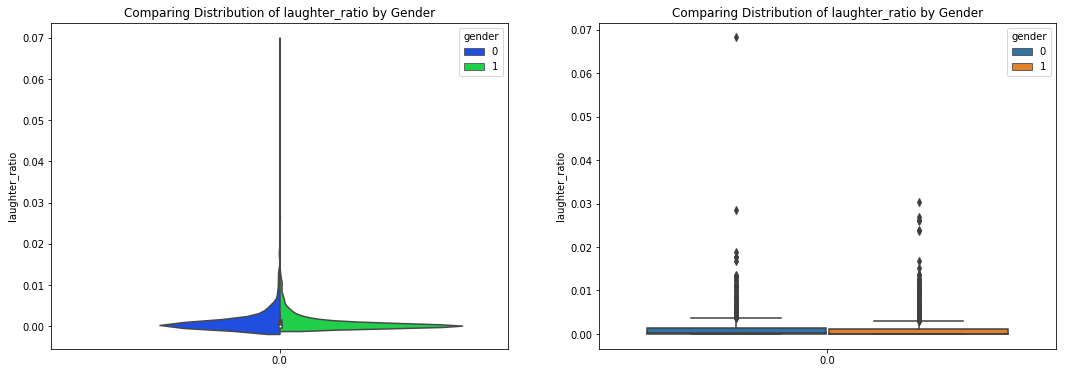

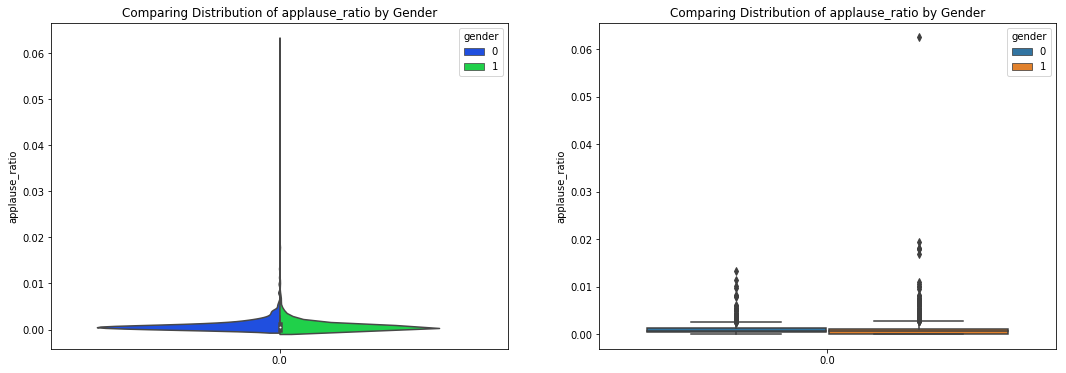

In [48]:
compareGenders('laughter_ratio')
compareGenders('applause_ratio')

In looking at this, we discovered some transcripts that did not have the words of the speeech besides (applause) and (laughter). We went back and removed these from the set so they are not shown here.  

['comments', 'duration', 'film_date', 'languages', 'num_speaker', 'published_date', 'views', 'polarity', 'subjectivity', 'Courageous', 'OK', 'Informative', 'Confusing', 'Jaw-dropping', 'Longwinded', 'Ingenious', 'Funny', 'Obnoxious', 'Unconvincing', 'Persuasive', 'Inspiring', 'Beautiful', 'Fascinating', 'WPM', 'laughter_ratio', 'applause_ratio']
CV for number of estimators:  59
Model Report:
Accuracy (Train) : 0.9182
AUC Score (Train): 0.982466
Accuracy (Test) : 0.6441
AUC Score (Test): 0.674714


/home/humble-fool/school_work/Spring_18/Data-Science-Lab-Final-Project/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/humble-fool/school_work/Spring_18/Data-Science-Lab-Final-Project/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


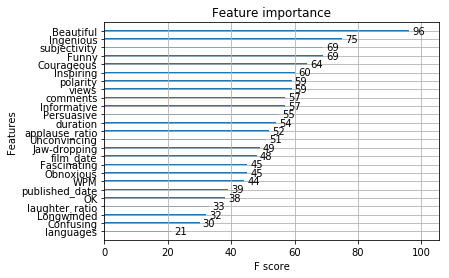

In [49]:
new_predictors = [feature for feature in data.select_dtypes(include=[np.number]).columns if feature not in ['gender']]
print(new_predictors)
xgbFit(xgb1, data, new_predictors)

Adding in the laugh ratio features seem to actually hurt our model, having it overfit to the training set and become worse on the validation set. It seems laughter ratios are pretty equal for men and women, and are just added noise to our model. (For gender prediction only. Note that these values may prove helpful in predicting views)For now, I'll remove them from the dataframe. 

In [50]:
# data = data.drop(labels=['laughter_ratio','applause_ratio'],axis=1) # Unsure about this

Removing the stop words... 
Removing the stop words... 


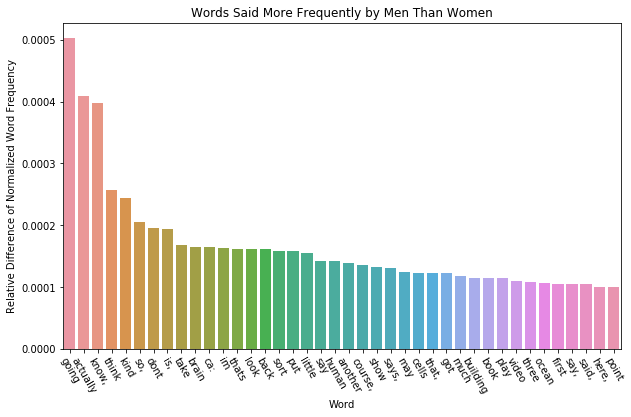

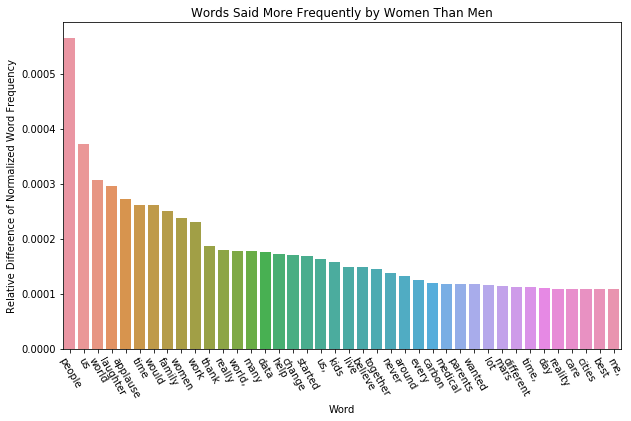

In [62]:
def sortWordsByGenderGap():
    normalizedMaleWordCounts, normalizedFemaleWordCounts = getNormalizedGenderWordCounts()
    doneWords = set() # To keep track of the words we've done
    genderGap = dict() # To record differnce by gender of word frequency
    
    # Loop through all male words and get gender difference
    for word, maleCount in normalizedMaleWordCounts.items():
        doneWords.add(word)
        if word in normalizedFemaleWordCounts.keys():
            femaleCount = normalizedFemaleWordCounts[word]
        else:
            femaleCount = 0
        diff = maleCount-femaleCount
        genderGap[word] = diff
        
    for word, femaleCount in normalizedFemaleWordCounts.items():
        # We already went through every word in male dictionary, if we reach it here, word count for men is 0,
        # therefore the difference between men and women frequencies for this word is just the women frequency.
        if word not in doneWords:
            genderGap[word] = -femaleCount 
    sortedMenFirst = sorted(genderGap.items(), key=operator.itemgetter(1),reverse=True)
    sortedWomenFirst = sorted(genderGap.items(), key=operator.itemgetter(1),reverse=False)
    
    
    
    # Plot a histogram of words that men say more frequently than women 
    _ = plt.figure(figsize=(10,6))
    _ = sns.barplot(list(dict(sortedMenFirst[0:40]).keys()), list(dict(sortedMenFirst[0:40]).values()))
    title = ('Words Said More Frequently by Men Than Women')
    _ = plt.ylabel('Relative Difference of Normalized Word Frequency')
    _ = plt.xlabel('Word')
    _ = plt.title(title)
    _ = plt.xticks(rotation=300)
    plt.show()
    
    # Plot a histogram of words that women say more frequently than men 
    _ = plt.figure(figsize=(10,6))
    _ = sns.barplot(list(dict(sortedWomenFirst[0:40]).keys()), np.fabs(list(dict(sortedWomenFirst[0:40]).values())))
    title = ('Words Said More Frequently by Women Than Men')
    _ = plt.title(title)
    _ = plt.ylabel('Relative Difference of Normalized Word Frequency')
    _ = plt.xlabel('Word')
    _ = plt.xticks(rotation=300)
    plt.show()
    return sortedMenFirst

_ = sortWordsByGenderGap()

Flagging some times of these high frequency difference words may help our classifier learn better!

### Now that we've explored into the differences of men and women's speech patterns, let's create some new features based off of what we haved learned!
The plan is to 
<br>1) Count word frequency of "high frequency male/female words"
<br>2) Count word frequency of word categories that proved to be different between genders
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;a) warm and agreeable
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;b) cold hearted
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;c) uncertainty
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;d) intensifiers
<br>3) Flag duration above a certain threshold
<br>4) Flag date published < certain date and > certain date

In [52]:
# 1) Count word frequency of "high frequency male/female words"
highMaleFreq = ['going','actually','know,','think','kind']
highFemaleFreq = ['people','us','world','laughter','applause']
highFreqMaleWordCounts = []
highFreqFemaleWordCounts = []

# 2) Count frequency of words from a certain category 
warmAgreeable = ['family','friends','wonderful','blessed','amazing','loving','husband','thankful']
uncertainty = ['um','uh']
intensifiers = ['very','so','such','really','totally','too']
coldHearted = ['kill','kills','dead','killing','die','swear','dead','murder']
warmAgreeableCounts = []
uncertaintyCounts = []
intensifierCounts = []
coldHeartedCounts = []

# 3) Flag duration above a certain threshold
longTalks = []

# 4) Flag date published before and after certain values
oldTalks = []
newTalks = []

# Loop through every row in the dataframe and create these new features
for row in data.itertuples():
    
    words = row.clean_transcripts.split()
    
    # 1)
    talkMaleFreqCount = 0
    talkFemaleFreqCount = 0
    
    # 2)
    talkWarmAgreeableCount = 0
    talkColdHeartedCount = 0
    talkIntensifierCount = 0
    talkUncertaintyCount = 0
    
    for word in words:
        # 1) 
        if word in highMaleFreq:
            talkMaleFreqCount +=1
        if word in highFemaleFreq:
            talkFemaleFreqCount +=1
        
        # 2)
        if word in warmAgreeable:
            talkWarmAgreeableCount +=1
        if word in coldHearted:
            talkColdHeartedCount +=1
        if word in intensifiers:
            talkIntensifierCount +=1
        if word in uncertainty:
            talkUncertaintyCount +=1
    
    # 1)
    highFreqMaleWordCounts.append(talkMaleFreqCount/float(len(words)))
    highFreqFemaleWordCounts.append(talkFemaleFreqCount/float(len(words)))
    
    # 2)
    warmAgreeableCounts.append(talkWarmAgreeableCount/float(len(words)))
    uncertaintyCounts.append(talkUncertaintyCount/float(len(words)))
    intensifierCounts.append(talkIntensifierCount/float(len(words)))
    coldHeartedCounts.append(talkColdHeartedCount/float(len(words)))

    # 3) 
    if row.duration > 1000:
        longTalks.append(1)
    else:
        longTalks.append(0)
    
    # 4) 
    if row.published_date > 1400000000:
        newTalks.append(1)
        oldTalks.append(0)
    elif row.published_date < 1300000000:
        newTalks.append(0)
        oldTalks.append(1)
    else:
        newTalks.append(0)
        oldTalks.append(0)
            
# 1)    
data['commonMaleWordFreq'] = highFreqMaleWordCounts
data['commonFemaleWordFreq'] = highFreqFemaleWordCounts

# 2)
data['warmAgreeable'] = warmAgreeableCounts
data['uncertainty'] = uncertaintyCounts
data['intensifiers'] = intensifierCounts
data['coldHearted'] = coldHeartedCounts

# 3)
data['longTalk'] = longTalks

# 4)
data['newTalk'] = newTalks
data['oldTalk'] = oldTalks

data.head()

,transcript,url,clean_transcripts,comments,description,duration,event,film_date,languages,main_speaker,...,applause_ratio,commonMaleWordFreq,commonFemaleWordFreq,warmAgreeable,uncertainty,intensifiers,coldHearted,longTalk,newTalk,oldTalk
0,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...,good morninghow are you\nlaughter\nits been gr...,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,...,0.001020,0.011224,0.020068,0.001361,0.0,0.006463,0.000000,1,0,1
1,"Thank you so much, Chris. And it's truly a gre...",https://www.ted.com/talks/al_gore_on_averting_...,"thank you so much, chrisand its truly a great ...",265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,...,0.002972,0.005448,0.020307,0.001486,0.0,0.007925,0.000000,0,0,1
2,"(Music: ""The Sound of Silence,"" Simon & Garfun...",https://www.ted.com/talks/david_pogue_says_sim...,"music: the sound of silence, simon & garfunkel...",124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,...,0.003550,0.006776,0.017425,0.000323,0.0,0.011294,0.000000,1,0,1
3,If you're here today and I'm very happy that ...,https://www.ted.com/talks/majora_carter_s_tale...,if youre here today and im very happy that yo...,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,...,0.002073,0.003800,0.011744,0.001382,0.0,0.005181,0.000345,1,0,1
4,"About 10 years ago, I took on the task to teac...",https://www.ted.com/talks/hans_rosling_shows_t...,"about 10 years ago, i took on the task to teac...",593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,...,0.001017,0.002712,0.014915,0.002373,0.0,0.010169,0.000000,1,0,1


In [53]:
# 1) Count word frequency of "high frequency male/female words"
highMaleFreq = ['going','actually','know,','think','kind']
highFemaleFreq = ['people','us','world','laughter','applause']
highFreqMaleWordCounts = []
highFreqFemaleWordCounts = []

# 2) Count frequency of words from a certain category 
warmAgreeable = ['family','friends','wonderful','blessed','amazing','loving','husband','thankful']
uncertainty = ['um','uh']
intensifiers = ['very','so','such','really','totally','too']
coldHearted = ['kill','kills','dead','killing','die','swear','dead','murder']
warmAgreeableCounts = []
uncertaintyCounts = []
intensifierCounts = []
coldHeartedCounts = []

# 3) Flag duration above a certain threshold
longTalks = []

# 4) Flag date published before and after certain values
oldTalks = []
newTalks = []

# Loop through every row in the dataframe and create these new features
for row in johnsData.itertuples():
    
    words = row.clean_transcripts.split()
    
    # 1)
    talkMaleFreqCount = 0
    talkFemaleFreqCount = 0
    
    # 2)
    talkWarmAgreeableCount = 0
    talkColdHeartedCount = 0
    talkIntensifierCount = 0
    talkUncertaintyCount = 0
    
    for word in words:
        # 1) 
        if word in highMaleFreq:
            talkMaleFreqCount +=1
        if word in highFemaleFreq:
            talkFemaleFreqCount +=1
        
        # 2)
        if word in warmAgreeable:
            talkWarmAgreeableCount +=1
        if word in coldHearted:
            talkColdHeartedCount +=1
        if word in intensifiers:
            talkIntensifierCount +=1
        if word in uncertainty:
            talkUncertaintyCount +=1
    
    # 1)
    highFreqMaleWordCounts.append(talkMaleFreqCount/float(len(words)))
    highFreqFemaleWordCounts.append(talkFemaleFreqCount/float(len(words)))
    
    # 2)
    warmAgreeableCounts.append(talkWarmAgreeableCount/float(len(words)))
    uncertaintyCounts.append(talkUncertaintyCount/float(len(words)))
    intensifierCounts.append(talkIntensifierCount/float(len(words)))
    coldHeartedCounts.append(talkColdHeartedCount/float(len(words)))

    # 3) 
    if row.duration > 1000:
        longTalks.append(1)
    else:
        longTalks.append(0)
    
    # 4) 
    if row.published_date > 1400000000:
        newTalks.append(1)
        oldTalks.append(0)
    elif row.published_date < 1300000000:
        newTalks.append(0)
        oldTalks.append(1)
    else:
        newTalks.append(0)
        oldTalks.append(0)
            
# 1)    
johnsData['commonMaleWordFreq'] = highFreqMaleWordCounts
johnsData['commonFemaleWordFreq'] = highFreqFemaleWordCounts

# 2)
johnsData['warmAgreeable'] = warmAgreeableCounts
johnsData['uncertainty'] = uncertaintyCounts
johnsData['intensifiers'] = intensifierCounts
johnsData['coldHearted'] = coldHeartedCounts

# 3)
johnsData['longTalk'] = longTalks

# 4)
johnsData['newTalk'] = newTalks
johnsData['oldTalk'] = oldTalks

johnsData.head()

,transcript,url,clean_transcripts,comments,description,duration,event,film_date,languages,main_speaker,...,applause_ratio,commonMaleWordFreq,commonFemaleWordFreq,warmAgreeable,uncertainty,intensifiers,coldHearted,longTalk,newTalk,oldTalk
0,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...,good morninghow are you\nlaughter\nits been gr...,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,...,0.001020,0.011224,0.020068,0.001361,0.0,0.006463,0.000000,1,0,1
1,"Thank you so much, Chris. And it's truly a gre...",https://www.ted.com/talks/al_gore_on_averting_...,"thank you so much, chrisand its truly a great ...",265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,...,0.002972,0.005448,0.020307,0.001486,0.0,0.007925,0.000000,0,0,1
2,"(Music: ""The Sound of Silence,"" Simon & Garfun...",https://www.ted.com/talks/david_pogue_says_sim...,"music: the sound of silence, simon & garfunkel...",124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,...,0.003550,0.006776,0.017425,0.000323,0.0,0.011294,0.000000,1,0,1
4,"About 10 years ago, I took on the task to teac...",https://www.ted.com/talks/hans_rosling_shows_t...,"about 10 years ago, i took on the task to teac...",593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,...,0.001017,0.002712,0.014915,0.002373,0.0,0.010169,0.000000,1,0,1
5,Thank you. I have to tell you I'm both challen...,https://www.ted.com/talks/tony_robbins_asks_wh...,thank youi have to tell you im both challenged...,672,"Tony Robbins discusses the ""invisible forces"" ...",1305,TED2006,1138838400,36,Tony Robbins,...,0.000756,0.007060,0.014624,0.001513,0.0,0.006051,0.000504,1,0,1


['comments', 'duration', 'film_date', 'languages', 'num_speaker', 'published_date', 'views', 'polarity', 'subjectivity', 'Courageous', 'OK', 'Informative', 'Confusing', 'Jaw-dropping', 'Longwinded', 'Ingenious', 'Funny', 'Obnoxious', 'Unconvincing', 'Persuasive', 'Inspiring', 'Beautiful', 'Fascinating', 'WPM', 'laughter_ratio', 'applause_ratio', 'commonMaleWordFreq', 'commonFemaleWordFreq']
CV for number of estimators:  59
Model Report:
Accuracy (Train) : 0.9321
AUC Score (Train): 0.988307
Accuracy (Test) : 0.6401
AUC Score (Test): 0.660244


/home/humble-fool/school_work/Spring_18/Data-Science-Lab-Final-Project/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/humble-fool/school_work/Spring_18/Data-Science-Lab-Final-Project/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


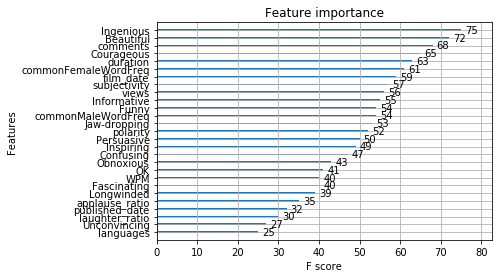

In [54]:
new_predictors = [feature for feature in data.select_dtypes(include=[np.number]).columns if feature not in ['gender','warmAgreeable','uncertainty','intensifiers','coldHearted','longTalk','newTalk','oldTalk']]
print(new_predictors)
xgbFit(xgb1, data, new_predictors)

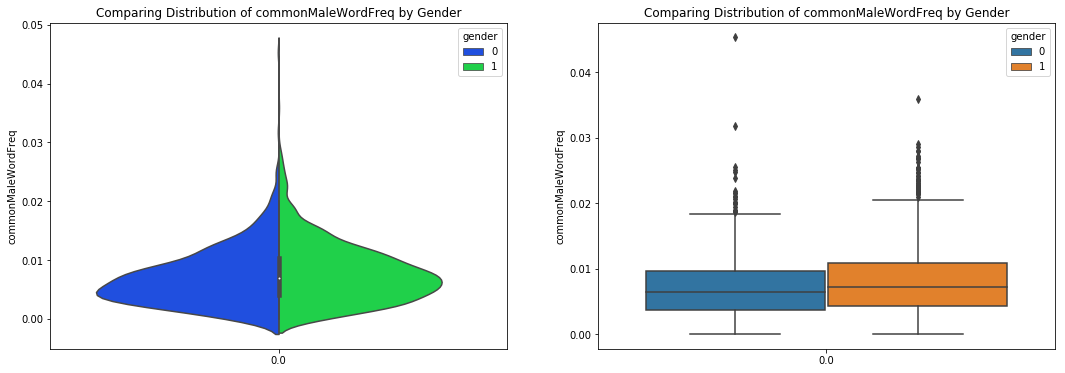

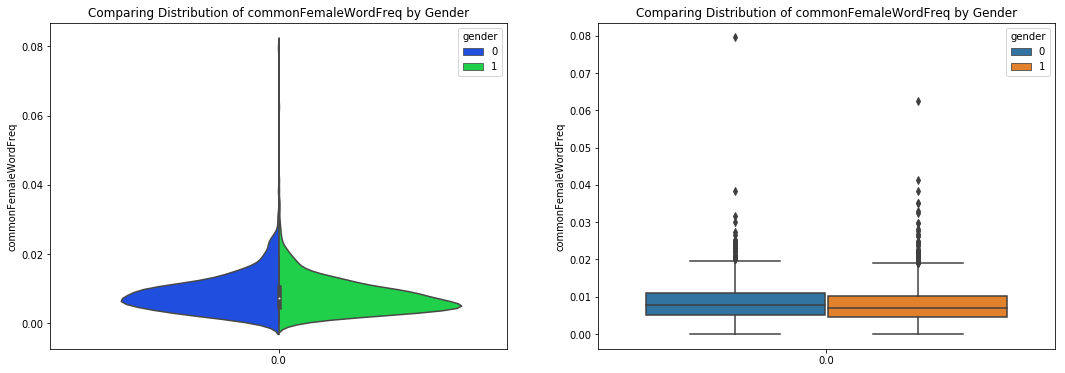

In [55]:
compareGenders('commonMaleWordFreq')
compareGenders('commonFemaleWordFreq')

['comments', 'duration', 'film_date', 'languages', 'num_speaker', 'published_date', 'views', 'polarity', 'subjectivity', 'Courageous', 'OK', 'Informative', 'Confusing', 'Jaw-dropping', 'Longwinded', 'Ingenious', 'Funny', 'Obnoxious', 'Unconvincing', 'Persuasive', 'Inspiring', 'Beautiful', 'Fascinating', 'WPM', 'laughter_ratio', 'applause_ratio', 'commonMaleWordFreq', 'commonFemaleWordFreq', 'warmAgreeable', 'uncertainty', 'intensifiers', 'coldHearted']
CV for number of estimators:  59
Model Report:
Accuracy (Train) : 0.9304
AUC Score (Train): 0.988204
Accuracy (Test) : 0.6468
AUC Score (Test): 0.665524


/home/humble-fool/school_work/Spring_18/Data-Science-Lab-Final-Project/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/humble-fool/school_work/Spring_18/Data-Science-Lab-Final-Project/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


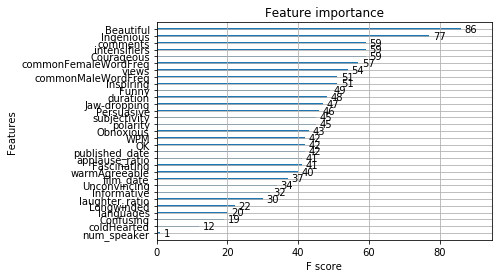

In [56]:
new_predictors = [feature for feature in data.select_dtypes(include=[np.number]).columns if feature not in ['gender','longTalk','newTalk','oldTalk']]
print(new_predictors)
xgbFit(xgb1, data, new_predictors)

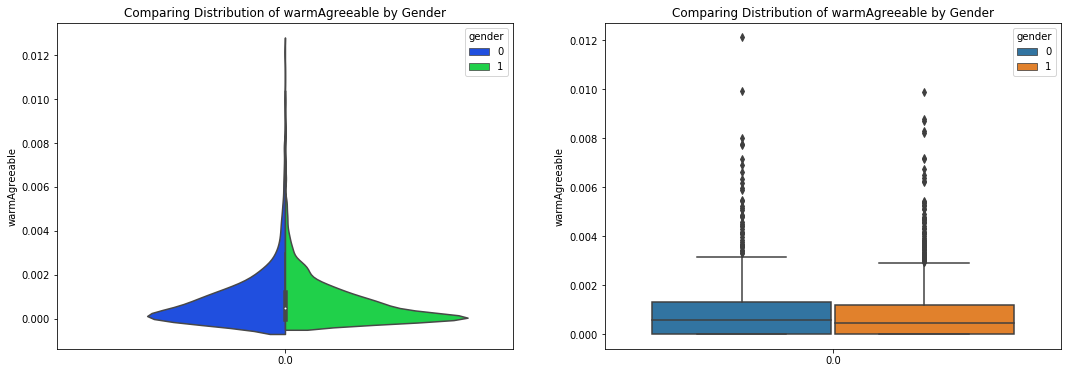

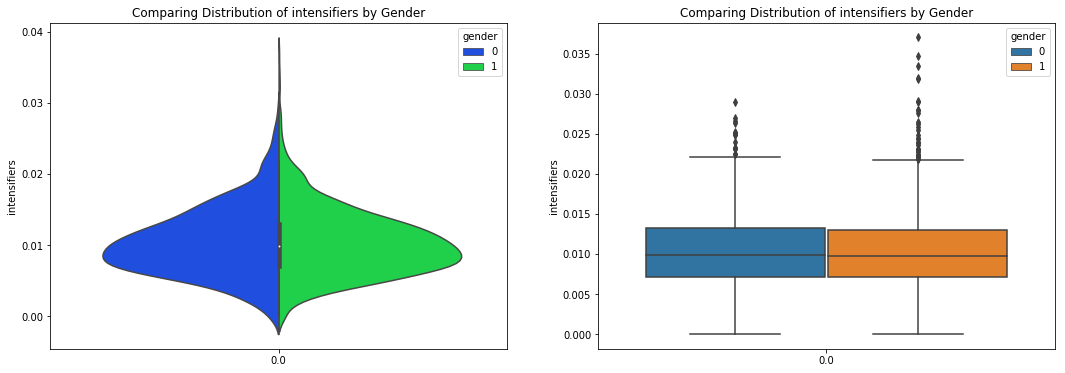

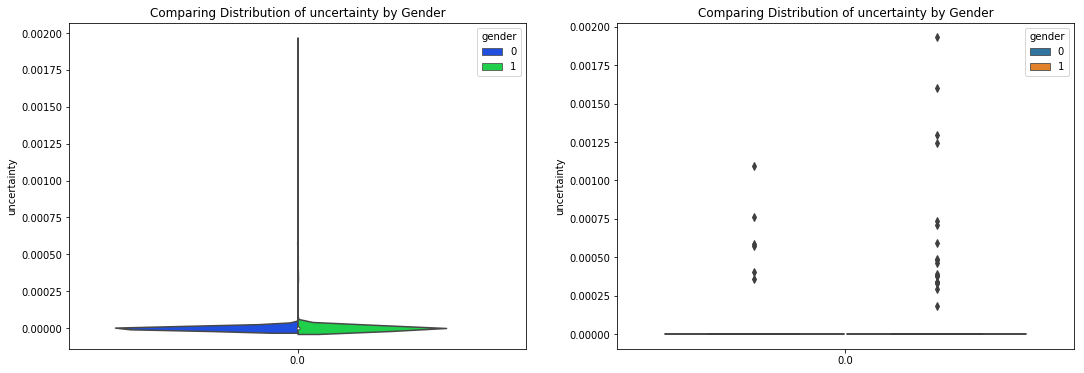

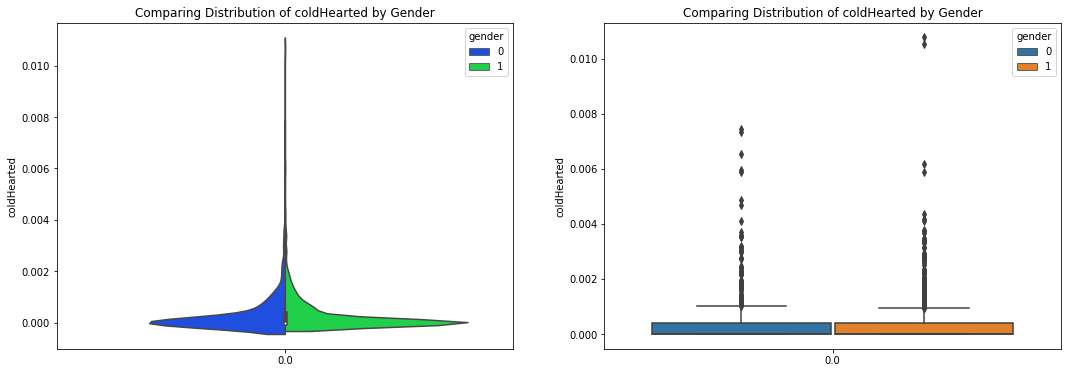

In [57]:
compareGenders('warmAgreeable')
compareGenders('intensifiers')
compareGenders('uncertainty')
compareGenders('coldHearted')

['comments', 'duration', 'film_date', 'languages', 'num_speaker', 'published_date', 'views', 'polarity', 'subjectivity', 'Courageous', 'OK', 'Informative', 'Confusing', 'Jaw-dropping', 'Longwinded', 'Ingenious', 'Funny', 'Obnoxious', 'Unconvincing', 'Persuasive', 'Inspiring', 'Beautiful', 'Fascinating', 'WPM', 'applause_ratio', 'commonMaleWordFreq', 'commonFemaleWordFreq', 'warmAgreeable', 'uncertainty', 'intensifiers', 'coldHearted', 'longTalk', 'newTalk', 'oldTalk']
CV for number of estimators:  59
Model Report:
Accuracy (Train) : 0.9432
AUC Score (Train): 0.989460
Accuracy (Test) : 0.6576
AUC Score (Test): 0.669324


/home/humble-fool/school_work/Spring_18/Data-Science-Lab-Final-Project/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/humble-fool/school_work/Spring_18/Data-Science-Lab-Final-Project/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


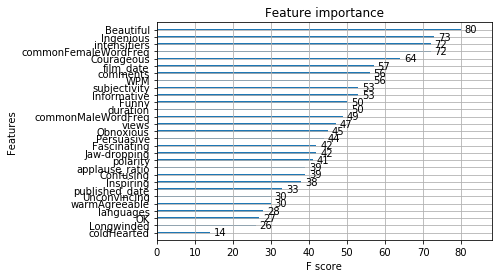

In [58]:
new_predictors = [feature for feature in data.select_dtypes(include=[np.number]).columns if feature not in ['gender','laughter_ratio']]
print(new_predictors)
xgbFit(xgb1, data, new_predictors)

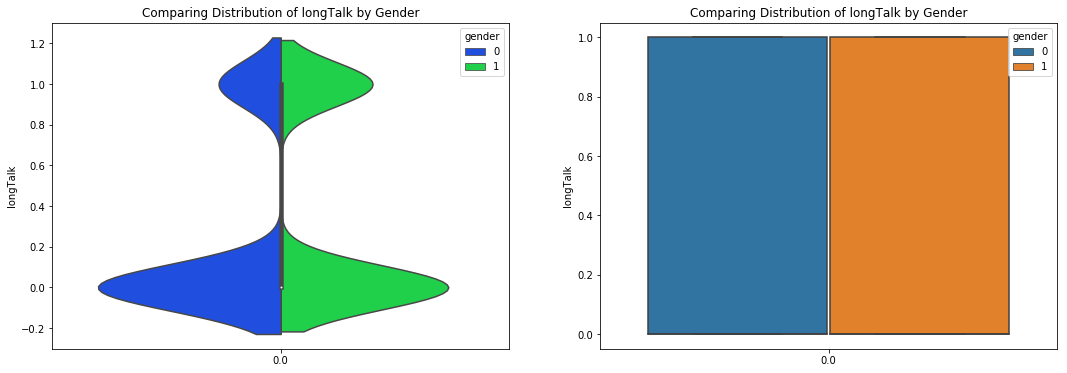

In [59]:
compareGenders('longTalk')

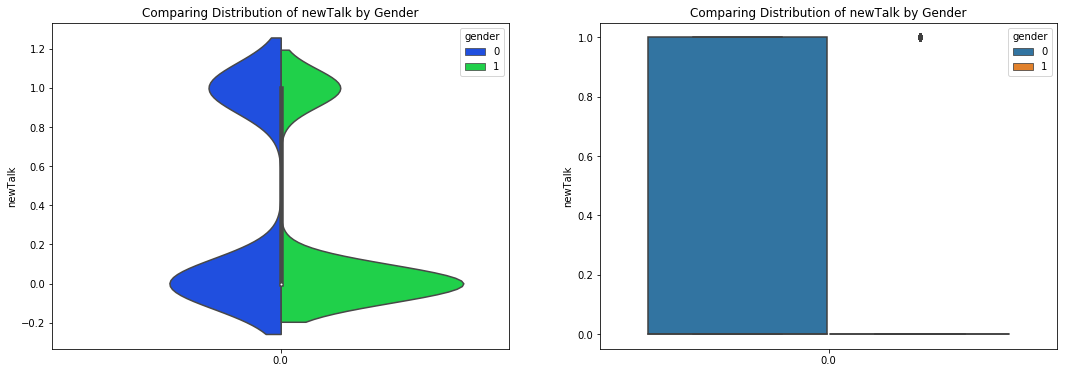

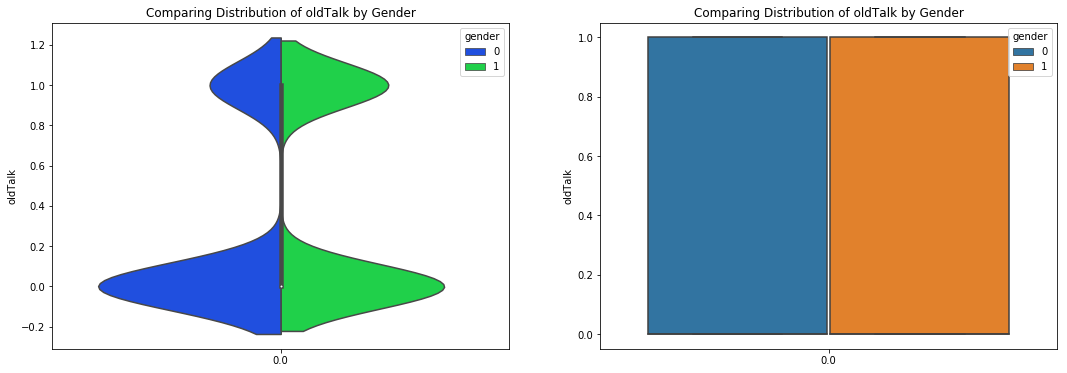

In [60]:
compareGenders('newTalk')
compareGenders('oldTalk')

Let's see if there are any interesting correlations between some of our new features and other features:

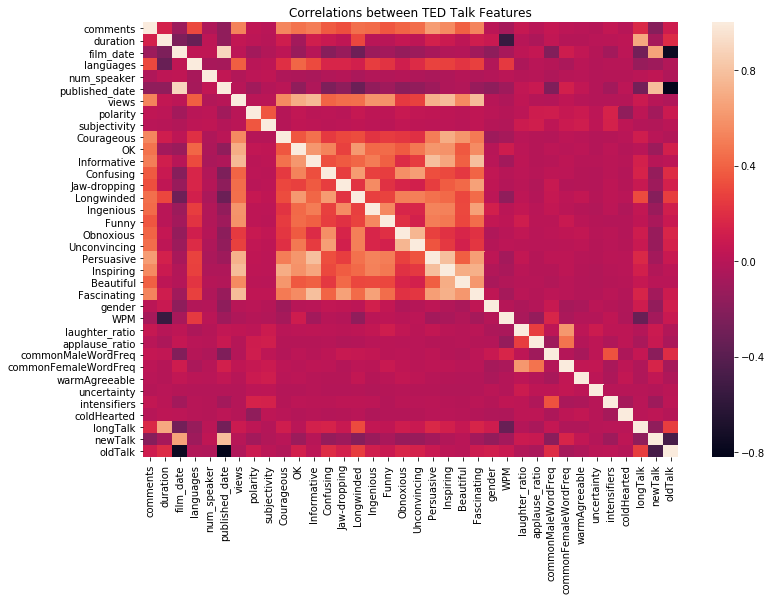

In [61]:
correlations = data.corr()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
_ = sns.heatmap(correlations,ax=axes)
_ = plt.title('Correlations between TED Talk Features')
plt.show()

Some interesting correlations:<br>
1) Comments and long talks are positively correlated<br>
2) Long talks and old talks are positively correlated<br>
3) WPM and languages are positively correlated<br>
4) Common female words frequency is positively correlated with laughter ratio and applause ratio<br>

### Let's rerun our basic xgb classifier and see if these new features help us any:

CV for number of estimators:  47
Model Report:
Accuracy (Train) : 0.9432
AUC Score (Train): 0.989224
Accuracy (Test) : 0.6455
AUC Score (Test): 0.646882


/home/humble-fool/school_work/Spring_18/Data-Science-Lab-Final-Project/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/humble-fool/school_work/Spring_18/Data-Science-Lab-Final-Project/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


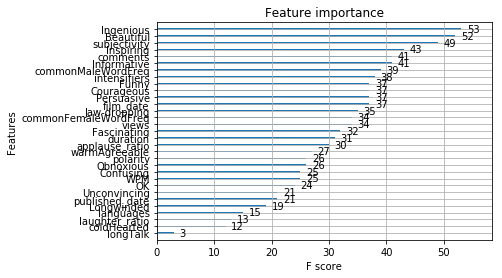

In [62]:
#Choose all predictors except target
predictors = [feature for feature in data.select_dtypes(include=[np.number]).columns if feature not in ['gender']]
# print(predictors)
xgb2 = XGBClassifier(
 learning_rate =0.15,
 n_estimators=1000,
 max_depth=7,
 min_child_weight=5,
 gamma=0.8,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=0.5, # Ratio of neg to pos classes
 seed=27)

xgbFit(xgb2, data, predictors)

In [63]:
johnsMetadata = johnsData.select_dtypes(include=np.number)
numEmpty= johnsMetadata.isnull().sum()
johnsMetadata.head()
print(numEmpty)

,comments,duration,film_date,languages,num_speaker,published_date,views,polarity,subjectivity,gender,...,applause_ratio,commonMaleWordFreq,commonFemaleWordFreq,warmAgreeable,uncertainty,intensifiers,coldHearted,longTalk,newTalk,oldTalk
0,4553,1164,1140825600,60,1,1151367060,47227110,0.146452,0.462051,0,...,0.001020,0.011224,0.020068,0.001361,0.0,0.006463,0.000000,1,0,1
1,265,977,1140825600,43,1,1151367060,3200520,0.157775,0.424101,0,...,0.002972,0.005448,0.020307,0.001486,0.0,0.007925,0.000000,0,0,1
2,124,1286,1140739200,26,1,1151367060,1636292,0.136579,0.475229,0,...,0.003550,0.006776,0.017425,0.000323,0.0,0.011294,0.000000,1,0,1
4,593,1190,1140566400,48,1,1151440680,12005869,0.096483,0.450631,0,...,0.001017,0.002712,0.014915,0.002373,0.0,0.010169,0.000000,1,0,1
5,672,1305,1138838400,36,1,1151440680,20685401,0.126712,0.520529,0,...,0.000756,0.007060,0.014624,0.001513,0.0,0.006051,0.000504,1,0,1


comments                0
duration                0
film_date               0
languages               0
num_speaker             0
published_date          0
views                   0
polarity                0
subjectivity            0
gender                  0
WPM                     0
applause_ratio          0
commonMaleWordFreq      0
commonFemaleWordFreq    0
warmAgreeable           0
uncertainty             0
intensifiers            0
coldHearted             0
longTalk                0
newTalk                 0
oldTalk                 0
dtype: int64


No empty values! Hoorah!

In [64]:
np.save('johns-special-metadata',johnsMetadata)

#### Trying to cluster the data

In [65]:
## This method generates k number of clusters specified in the function call. default value is 2.
def genClusters(dataFrame, k=2):
    vector_matrix = getTFIDFvectors(dataFrame)
    means = KMeans(k, random_state =0)
    result = means.fit_predict(vector_matrix)
    result_1 = means.fit_transform(vector_matrix)
    plt.scatter(result_1[:,0],result_1[:,1],c =result, cmap = 'autumn')
    plt.title("Basic Clustering without any transformation on the data")
    
    

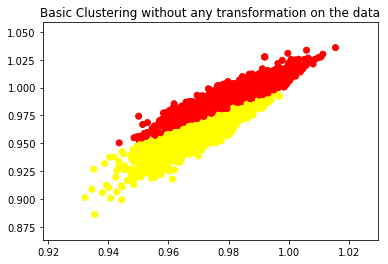

In [66]:
genClusters(data)

In [67]:
def genClusters_svd(dataFrame, k =2, n_comp = 5):
    vector_matrix = getTFIDFvectors(dataFrame)
    means = KMeans(k, random_state = 0)
    # doing TruncatedSVD on the matrix with specified number of components. PCA isn't supported on sparse matrices
    tSVD = TruncatedSVD(n_components = n_comp)
    transformed_vector_matrix = tSVD.fit_transform(vector_matrix)
    
    # Running Kmeans clustering algorithm on transformed data
    result = means.fit_predict(transformed_vector_matrix)
    result_1 = means.fit_transform(transformed_vector_matrix)
    plt.scatter(result_1[:,0],result_1[:,1],c =result, cmap = 'autumn')
    plt.title("Clustering the data after dimensionality reduction")

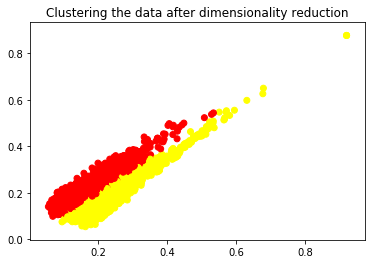

In [68]:
genClusters_svd(data,n_comp = 10)

In [69]:
# Checking feature importance for regression to predict number of views
relevant_features = ['comments','duration','film_date','languages','num_speaker','published_date','polarity','subjectivity']
model = ExtraTreesClassifier()
model.fit(data[relevant_features], data['views'])

# display the relative importance of each attribute
print(model.feature_importances_)

model1 = LinearRegression(normalize=True)
rfe = RFE(model1, 2)
rfe = rfe.fit(data[relevant_features], data['views'])
print(rfe.support_)
print(rfe.ranking_)


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

[0.14573517 0.14597888 0.14553209 0.12437043 0.00511779 0.14358245
 0.14516653 0.14451665]
[False False False False False False  True  True]
[4 5 7 2 3 6 1 1]


Based on Regression 2 most important features are polarity and subjectivity, which are columns generated using textblob

In [70]:
# Run a logistic regression with a CV score and validation score
def LogRegMetrics(features, labels, num_folds=5):
    accuracies = []
    aucs = []
    fprs = []
    tprs = []

    skf = StratifiedKFold(n_splits=num_folds)
    _ = skf.get_n_splits(features, labels)

    for train_index, test_index in skf.split(features, labels):
        rand = np.random.randint(1, 100)
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        clf = LogisticRegression(penalty='l2', max_iter=1000, random_state=rand)
        _ = clf.fit(X_train, y_train)
        accuracies.append(clf.score(X_test, y_test))
        pred = clf.predict(X_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
        auc = metrics.auc(fpr, tpr)
        fprs.append(fpr)
        tprs.append(tpr)
        aucs.append(auc)
 
    pred = clf.predict(validation.drop(['label'], axis=1))
    acc = clf.score(validation.drop(['label'], axis=1), validation.label)
    fpr, tpr, thresholds = metrics.roc_curve(validation.label, pred)
    auc = metrics.auc(fpr, tpr)

    print("Mean Accuracy for L2 norm is:\t\t\t{}".format(np.array(accuracies).mean()))
    print("St Dev for accuracy for L2 norm is:\t\t{}".format(np.std(accuracies, axis=0)))    
    print("Mean AUC for L2 norm is:\t\t\t{}".format(np.array(aucs).mean()))
    print("Mean True Positive Rate for L2 norm is:\t\t{}".format(np.array(tprs).mean()))
    print("Mean False Positive Rate for L2 norm is:\t{}".format(np.array(fprs).mean()))
    print("Validated accuracy score is:\t\t\t{}".format(acc))
    print("Validated area under the curve score is:\t{}".format(auc))

In [80]:
def rmse_cv(model,X_train,y):    
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)
def plot(cv_model, alphas):
    plt.figure(figsize = (10,8))
    solvers = ['svd', 'cholesky', 'lsqr']
    _ = plt.plot(alphas, cv_model[0,:], marker='.', label = solvers[0])
    _ = plt.plot(alphas, cv_model[1,:], marker=',', label = solvers[1])
    _ = plt.plot(alphas, cv_model[2,:], marker='o', label = solvers[2])
    plt.xlabel("Alpha", fontsize=12)
    plt.ylabel("RMSE", fontsize=12)
    _ = plt.title("Alpha vs. RMSE for different Alphas, Solvers", fontsize=15)
    _ = plt.legend()

In [77]:
# Function to run ridge regression on
# Inputs: dataframe containing features and label to predict
def runRidge(features, label, alphas):
    alphas1 =alphas
    X_train, X_test, y_train, y_test = train_test_split(features,label,shuffle=True,test_size=0.2)
    solvers = ['svd', 'cholesky', 'lsqr']
    num_alphas = 11
    cv_ridge = [[rmse_cv(Ridge(alpha = alpha, normalize=True, solver= solver),X_train,y_train).mean() 
            for alpha in alphas1] for solver in solvers]
    cv_ridge = np.array(cv_ridge)
    plot(cv_ridge,alphas1)
    

In [73]:
data.loc[0,:]

transcript              Good morning. How are you?(Laughter)It's been ...
url                     https://www.ted.com/talks/ken_robinson_says_sc...
clean_transcripts       good morninghow are you\nlaughter\nits been gr...
comments                                                             4553
description             Sir Ken Robinson makes an entertaining and pro...
duration                                                             1164
event                                                             TED2006
film_date                                                      1140825600
languages                                                              60
main_speaker                                                 Ken Robinson
name                            Ken Robinson: Do schools kill creativity?
num_speaker                                                             1
published_date                                                 1151367060
ratings                 [{'id': 7, 'na

In [78]:
features = ['comments','duration','languages','film_date','num_speaker','polarity','subjectivity','gender','WPM',
            'laughter_ratio','applause_ratio','commonMaleWordFreq','commonFemaleWordFreq','warmAgreeable','uncertainty',
            'intensifiers','coldHearted','longTalk','newTalk','oldTalk']
'applause_ratio','commonMaleWordFreq','commonFemaleWordFreq','uncertainty',
            'intensifiers','coldHearted'


        

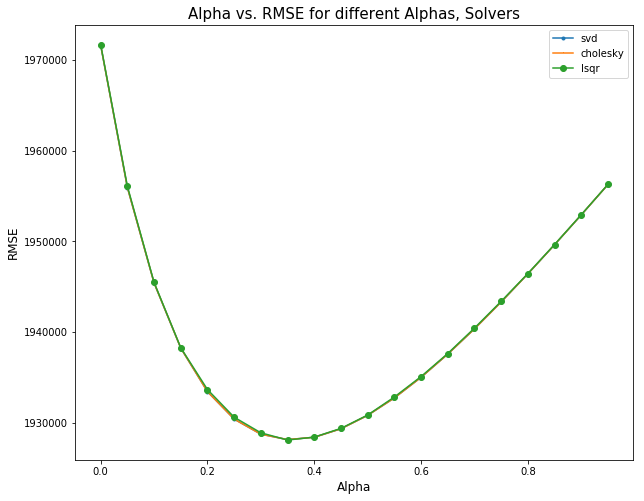

In [81]:
alphas = np.arange(0,1.0,0.05)
runRidge(data[features],data['views'],alphas)

Zooming in on the alphas to get more accurate value

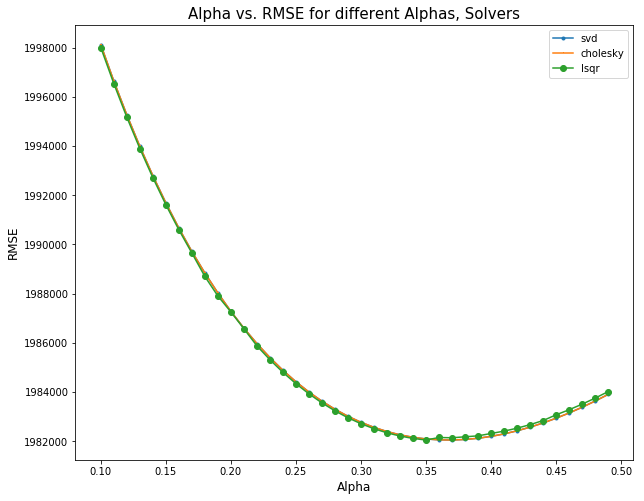

In [95]:
alphas = np.arange(0.1,0.5,0.01)
runRidge(data[features],data['views'],alphas)

#### Running Lasso Regression to predict number of views

In [115]:
def runLasso(features, label, alphas):
    alphas1 =alphas
    X_train, X_test, y_train, y_test = train_test_split(features,label,shuffle=True,test_size=0.2)
    solvers = ['svd', 'cholesky', 'lsqr']
    num_alphas = 11
    cv_ridge = [[rmse_cv(Lasso(alpha=alpha, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True),X_train,y_train).mean() 
            for alpha in alphas1] for solver in solvers]
    cv_ridge = np.array(cv_ridge)
    plot(cv_ridge,alphas1)

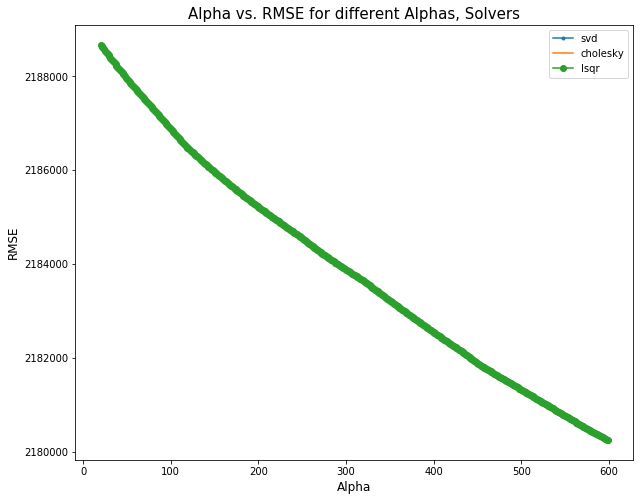

In [146]:
alphas = np.arange(20,600,1)
runLasso(data[features],data['views'],alphas)

#### Recursively eliminating features at alpha minimizing the squared error

In [147]:
model1 = Ridge(alpha=0.14, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True)
rfe = RFE(model1, 6)
rfe = rfe.fit(data[features], data['views'])
print(rfe.support_)
print(rfe.ranking_)
print(rfe.score(data[features],data['views']))

[False False False False False False False False False False  True  True
  True False  True  True  True False False False]
[10 14  8 15 11  6  3  9 13 12  1  1  1  2  1  1  1  4  7  5]
0.0023501125369468356


In [148]:
relevant_features = ['laughter_ratio','applause_ratio','commonMaleWordFreq','commonFemaleWordFreq','uncertainty',
            'intensifiers','coldHearted']

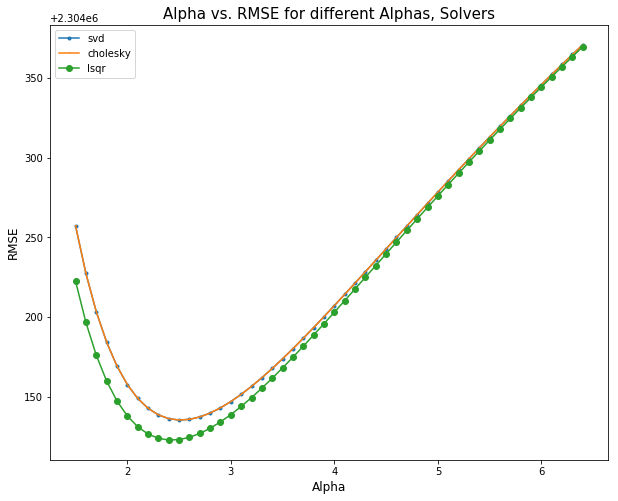

In [158]:
alphas = np.arange(1.5,6.5,0.1)
runRidge(data[relevant_features],data['views'],alphas)

Running the ridge regression model with selected features through recursive elimination didn't improve RMSE score.